$(0,1)$ differences may occur for instances with $10.2 < LSTAT < 19.2, ZN < 6, CRIM<7, AGE≥1$
- Differences: $11.1 ≤ LSTAT < 18.8, ZN=0$ (13 instances)
- CF: $CRIM≥7 \rightarrow (0,0)$
- R: $5.4 < LSTAT$
    - RL: $8.9 < LSTAT$
        - CF: $LSTAT≤10.2 \rightarrow (1,1)$
        - CF: $LSTAT≥19.2 \rightarrow (0,0)$
        - CF: $AGE=0 \rightarrow (0,0), (1,0)$
        - CF: $ZN≥6 \rightarrow (1,1)$

$(1,2)$ differences may occur for instances with $4.5 < LSTAT < 6.3, ZN < 90, INDUS < 9$
- Differences: 1 instance
- R: $LSTAT ≤ 13$
    - CF: $LSTAT ≤ 4.5 \rightarrow (2,2)$
    - CF: $LSTAT ≥ 6.3 \rightarrow (1,1)$
    - CF: $ZN≥90 \rightarrow (2,2)$
    - CF: $INDUS ≥ 9 \rightarrow (1,1)$

$(2,1)$ differences may occur for instances with $5.9 < LSTAT < 9.0, RM<7.3, DIS<4.2$
- Differences: $6.4 < LSTAT < 9.0$ 3 instances
- R: $LSTAT ≤ 13.0$
    - CF: $5.9 < LSTAT < 9.1$
    - RR: $LSTAT ≥ 6.1$
        - CF: $RM≥7.3 \rightarrow (2,2)$
        - CF: $DIS≥4.2 \rightarrow (1,1)$

Compared to the explanations that were created using the exact SHAP algorithm, these are essentially the same, except that for the other the trends are clearer (with less disturbances), which results in better readable explanations per cluster as well.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from sklearn.metrics import classification_report
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from util import RuleClassifier
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [2]:
try:
    with open('shap.permutation.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
categorical_features = ['AGE']
feature_precisions = [0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2]

In [4]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [6]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.permutation.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Using Permutation algorithm
Using Permutation algorithm
Using Permutation algorithm


Permutation explainer: 247it [00:14,  6.01it/s]                         
Permutation explainer: 247it [00:12,  2.68it/s]                         
Permutation explainer: 247it [00:49,  3.91it/s]                         

CPU times: user 1min 43s, sys: 9.67 s, total: 1min 52s
Wall time: 1min 15s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

# Traditional SHAP Explanations

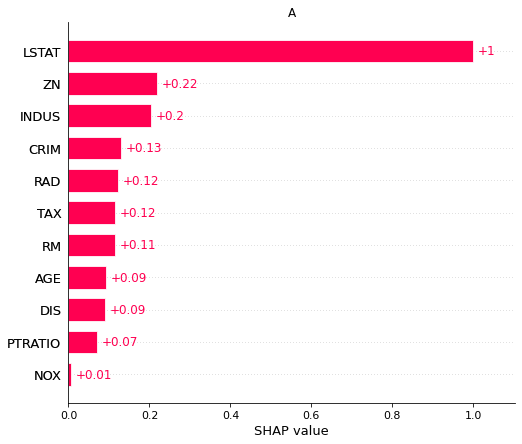

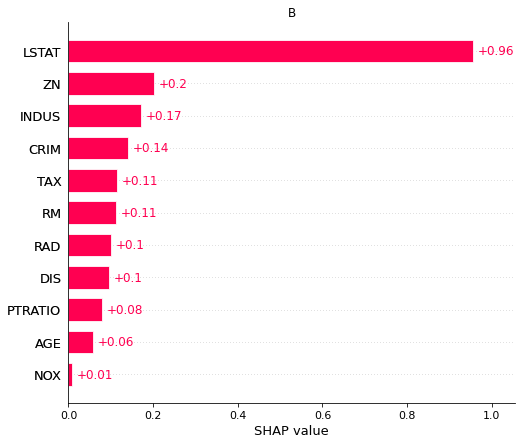

In [4]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [5]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
feature_order = feature_order[:-1]

In [6]:
node, Z = make_clustering(comparer, explanations.indiv.log_odds, categorical_features=categorical_features)

root
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


In [7]:
feature_it = iter(feature_order)

In [8]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature(feature, classes=list(classes), alpha=0.5)

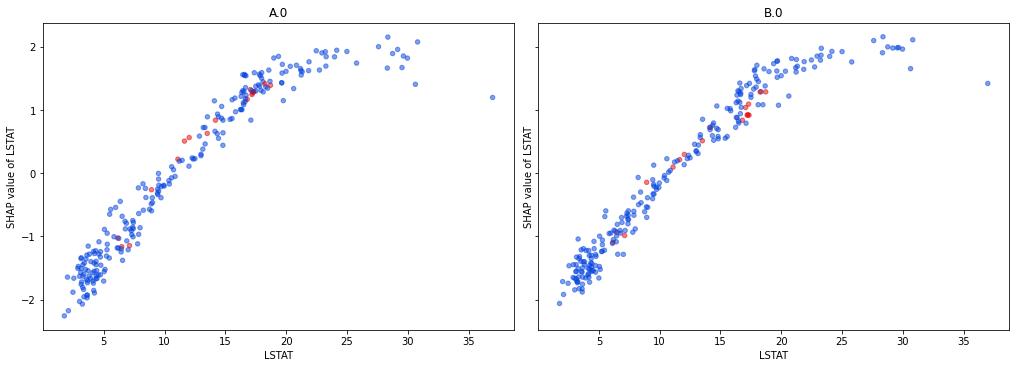

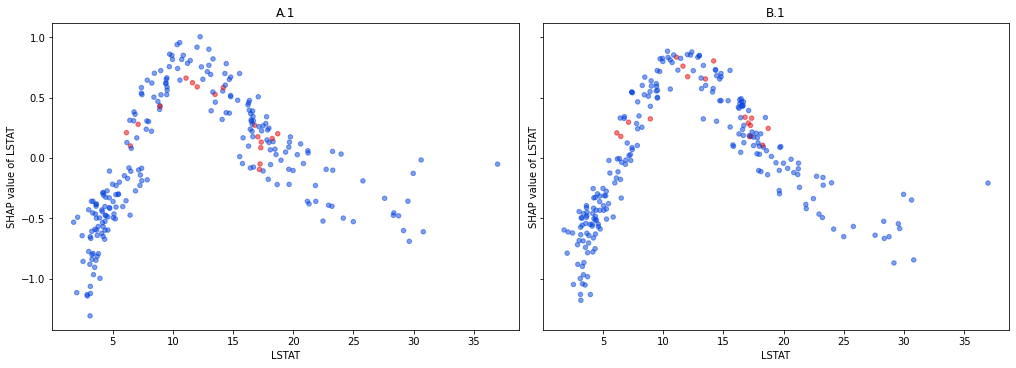

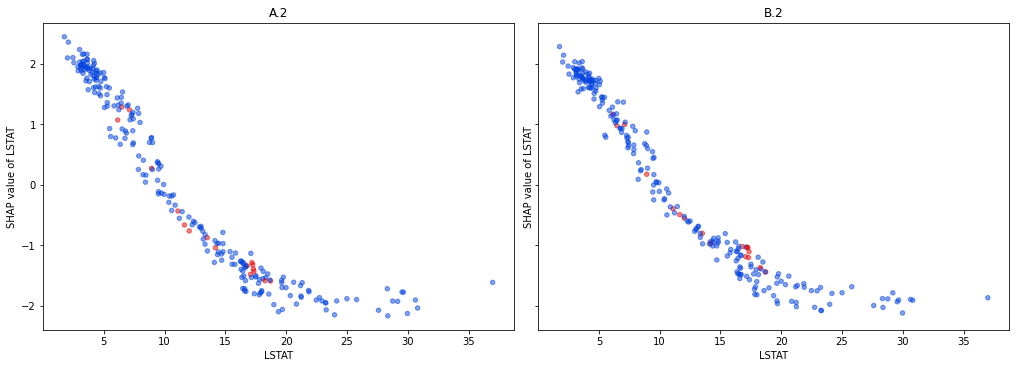

In [9]:
plot_next_feature()

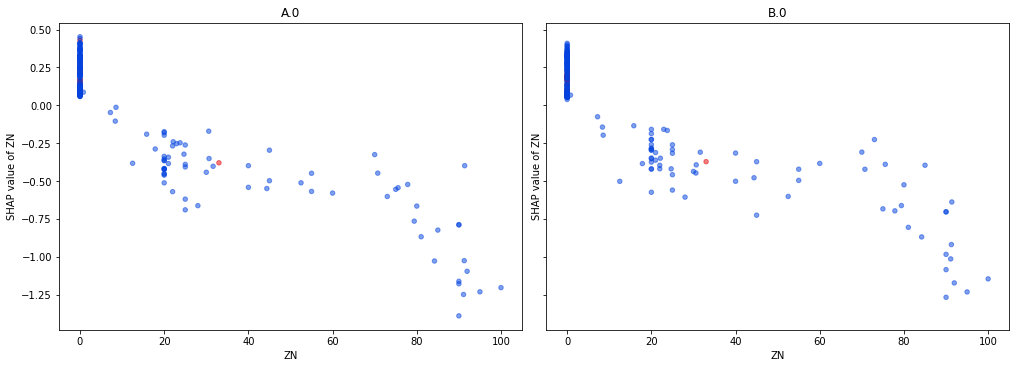

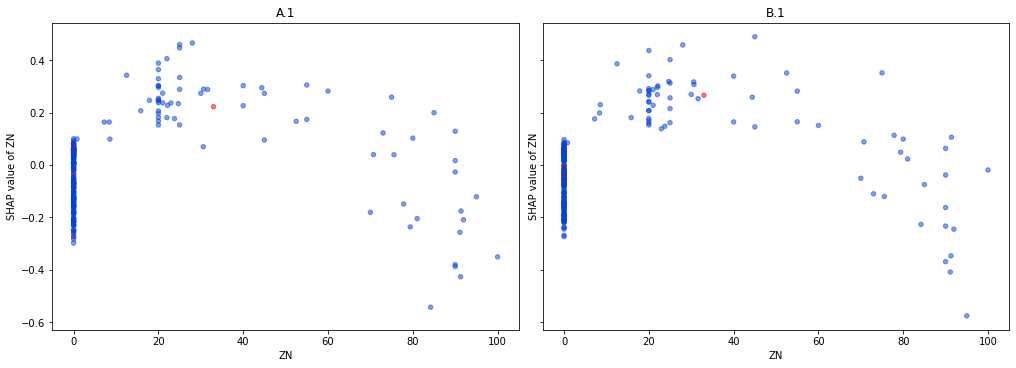

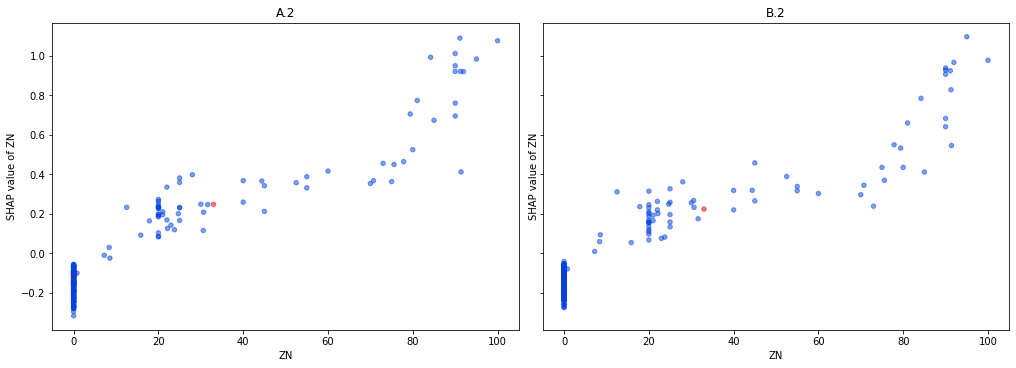

In [10]:
plot_next_feature()

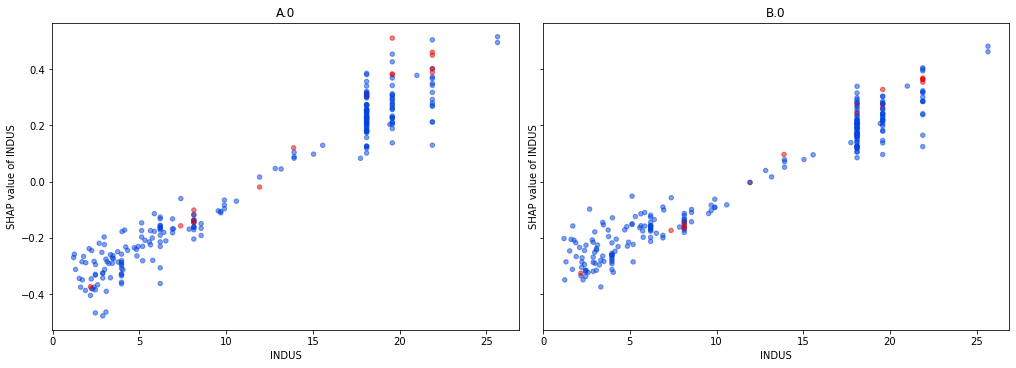

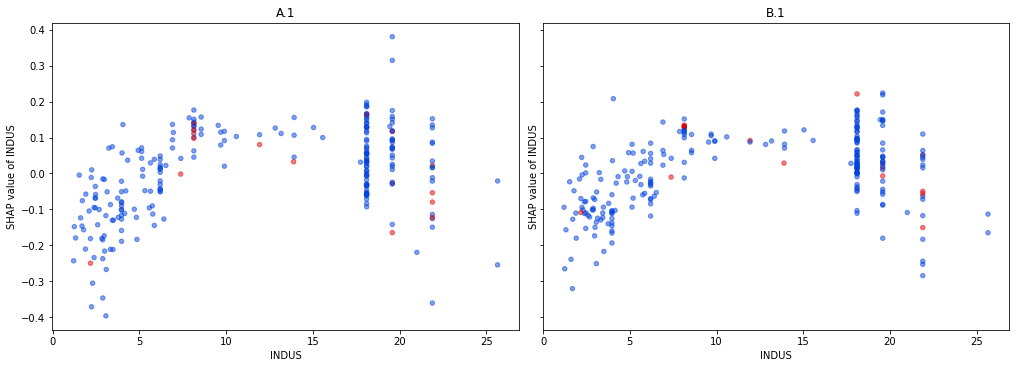

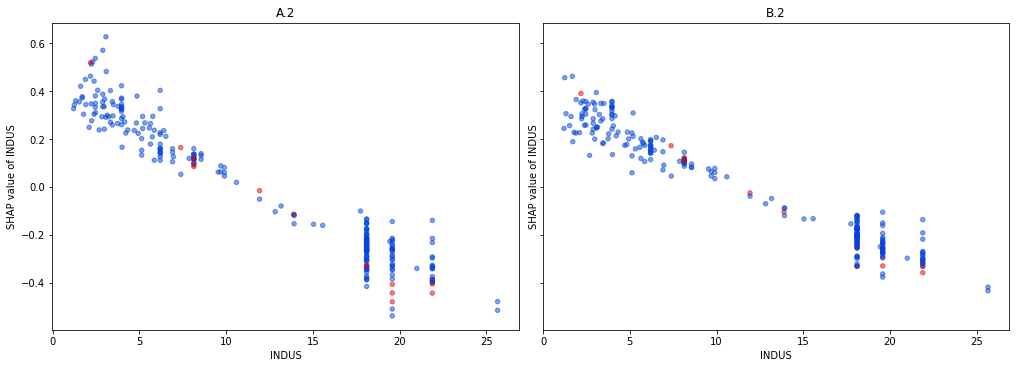

In [11]:
plot_next_feature()

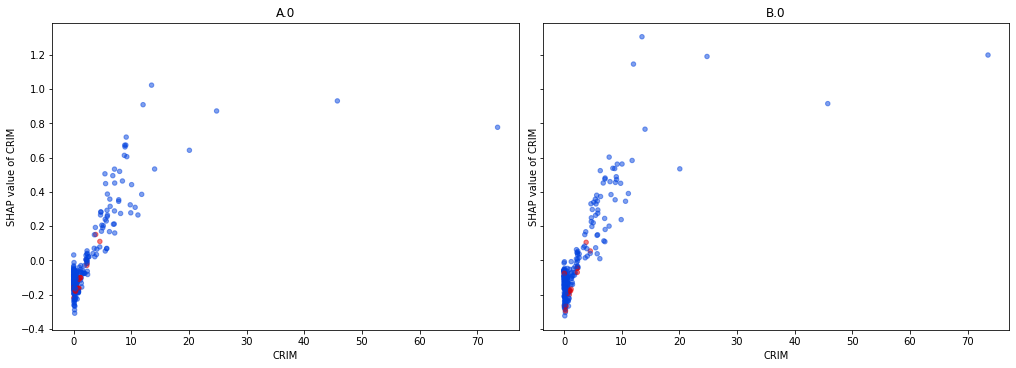

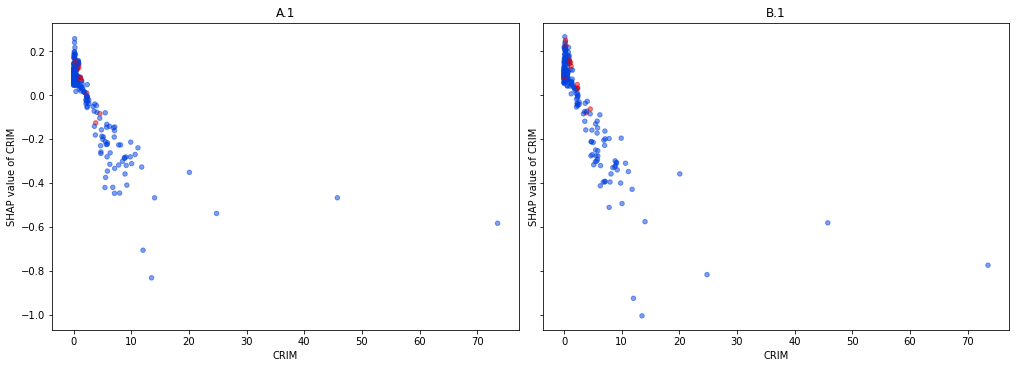

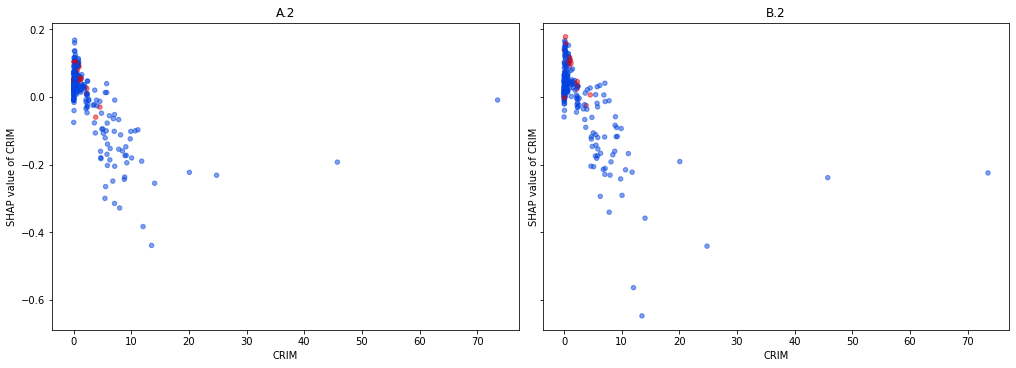

In [12]:
plot_next_feature()

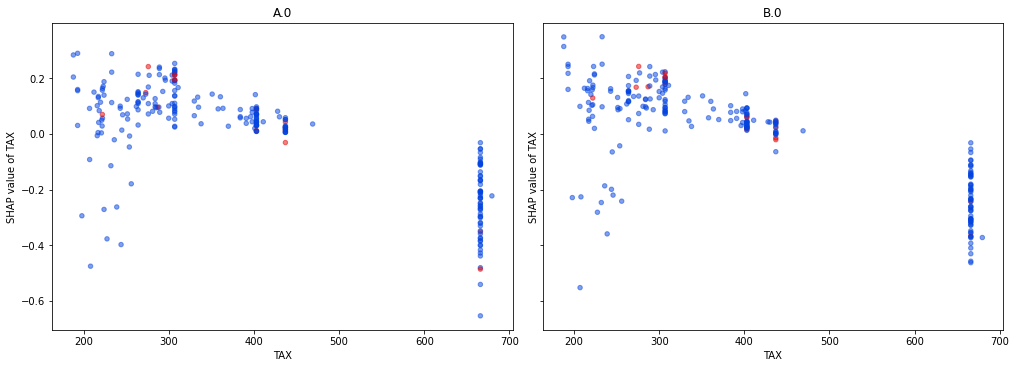

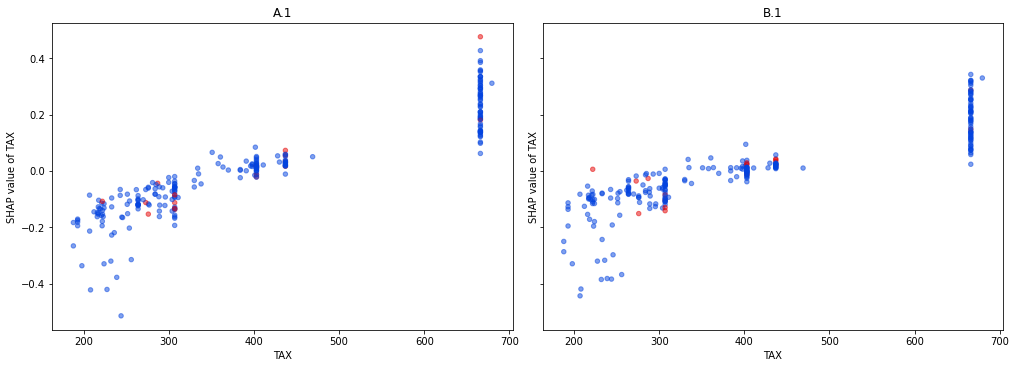

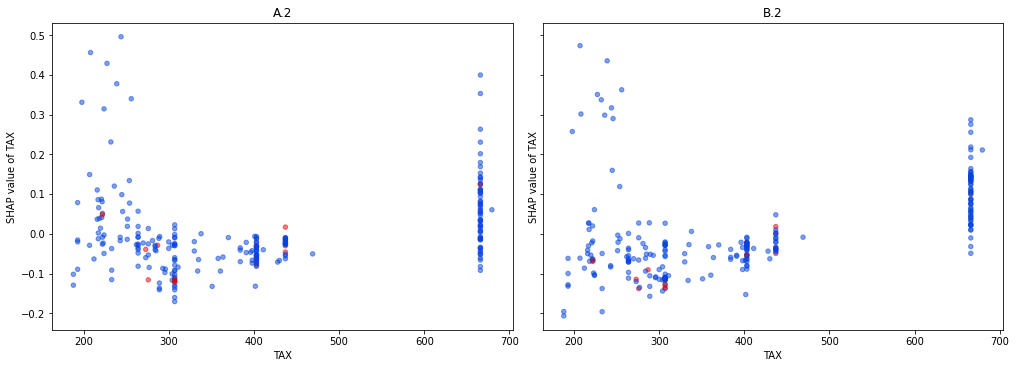

In [13]:
plot_next_feature()

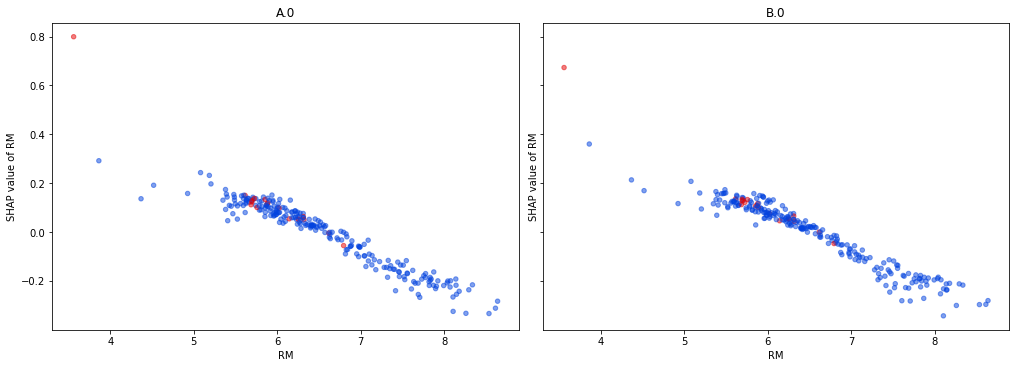

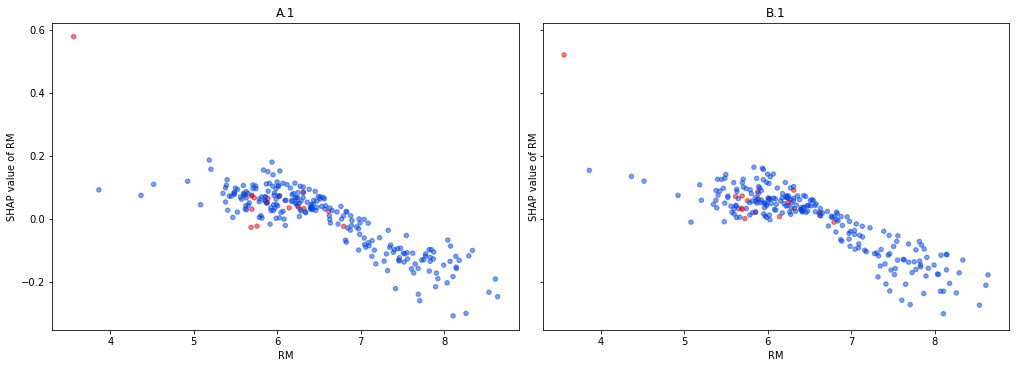

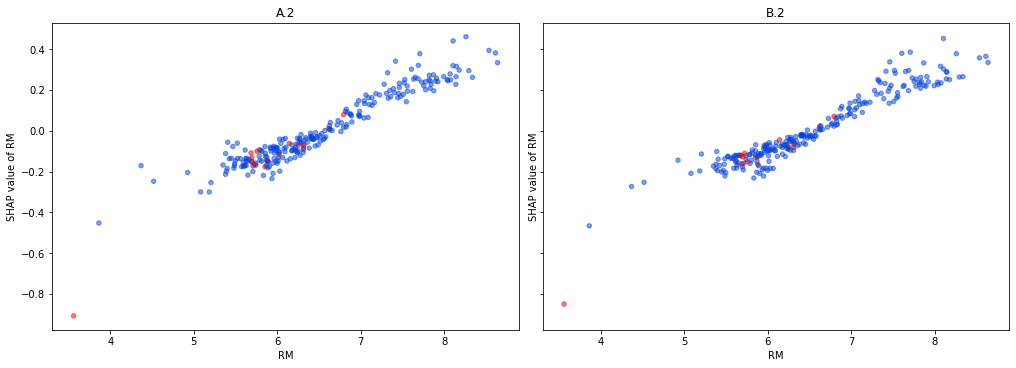

In [14]:
plot_next_feature()

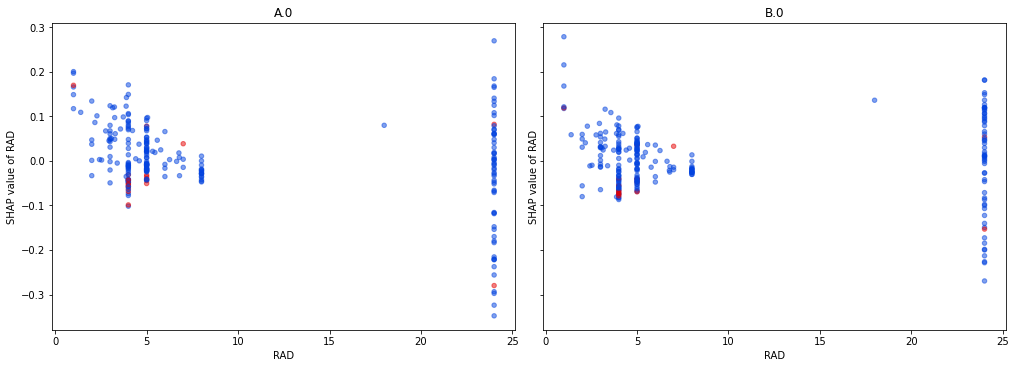

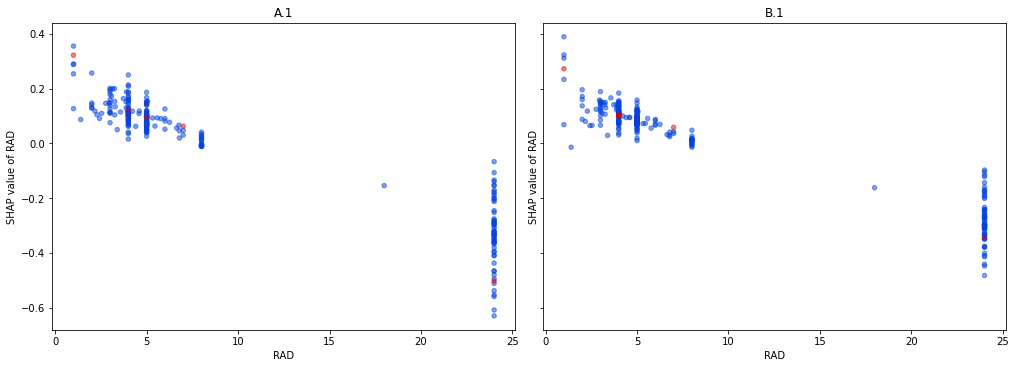

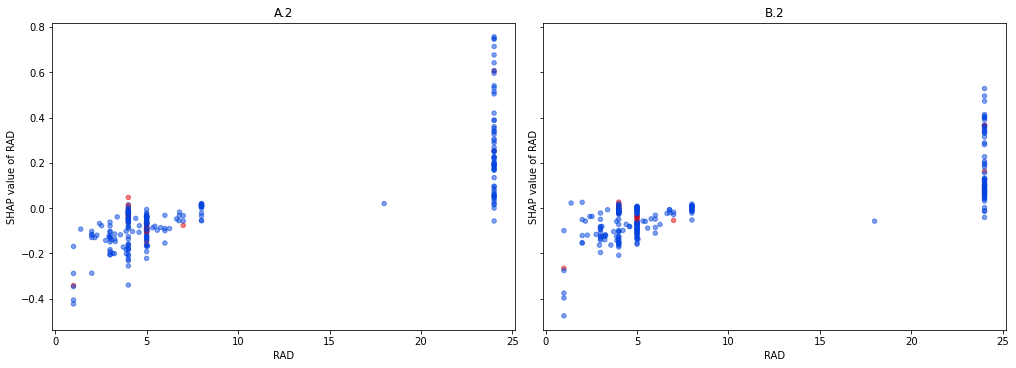

In [15]:
plot_next_feature()

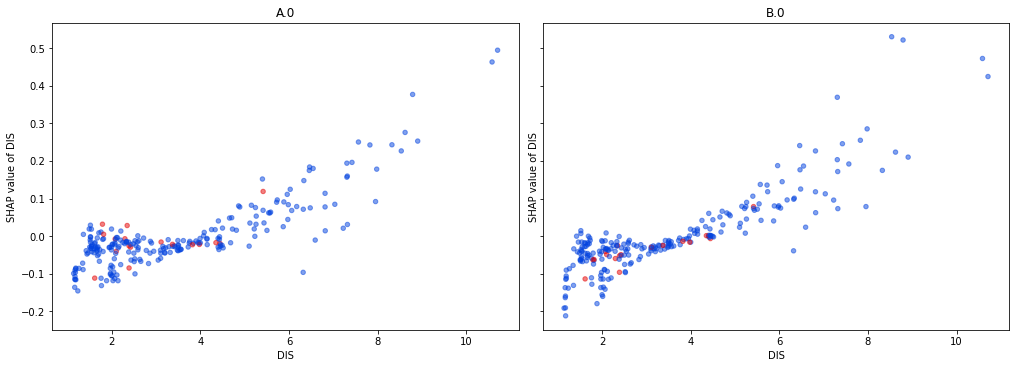

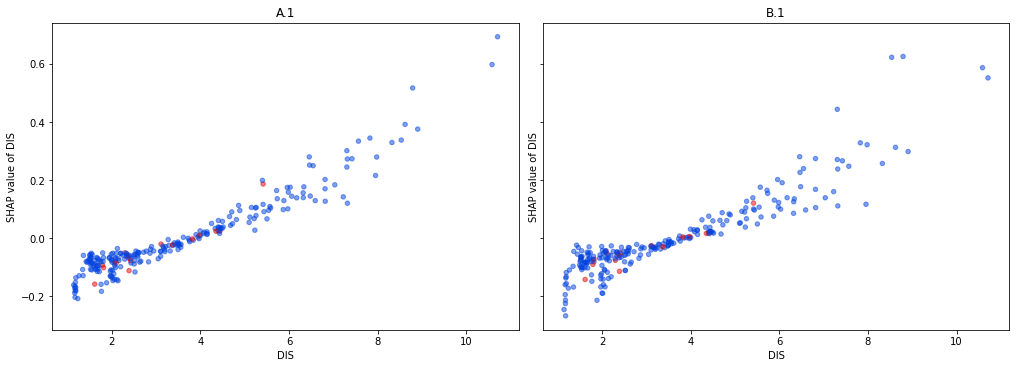

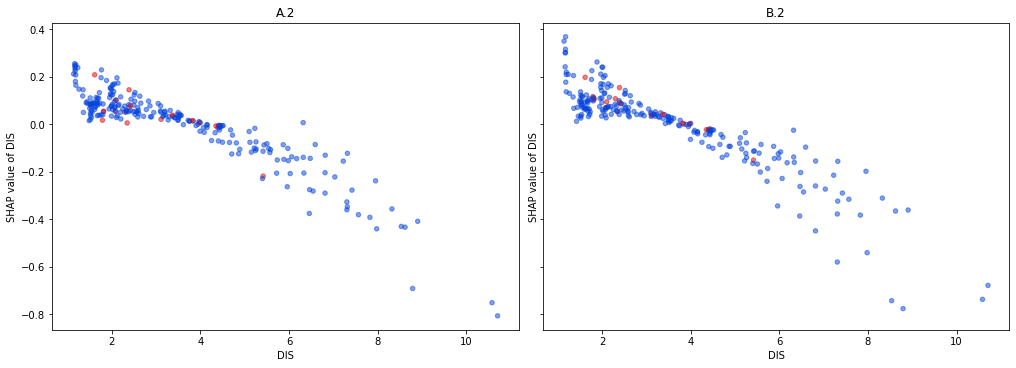

In [16]:
plot_next_feature()

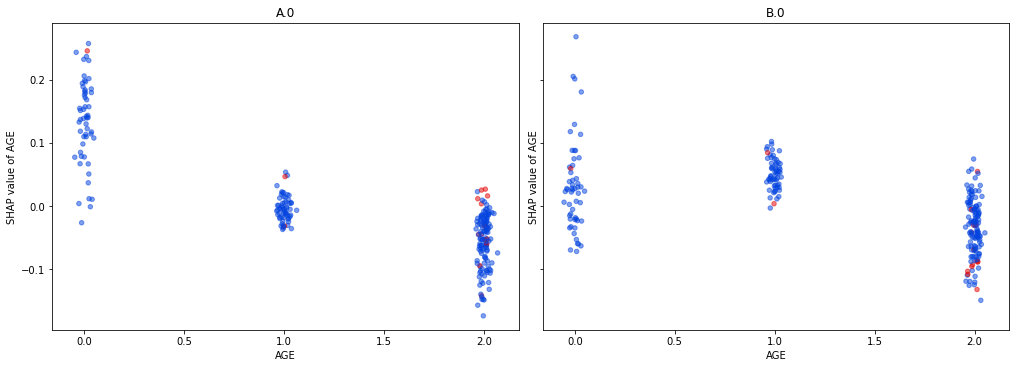

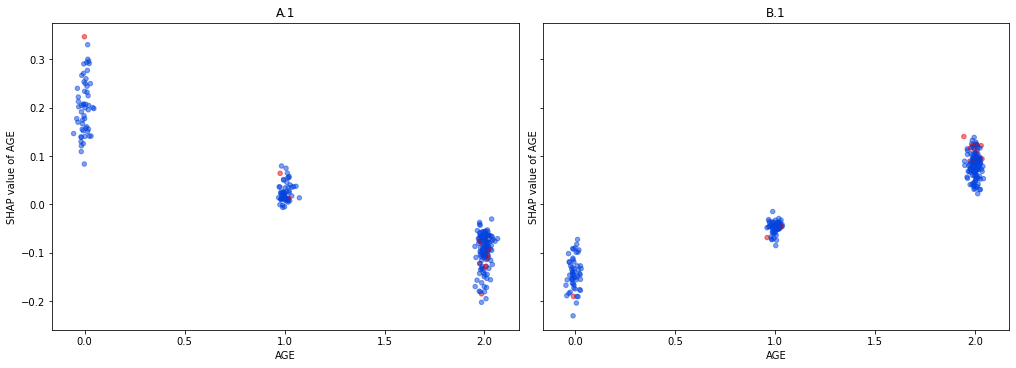

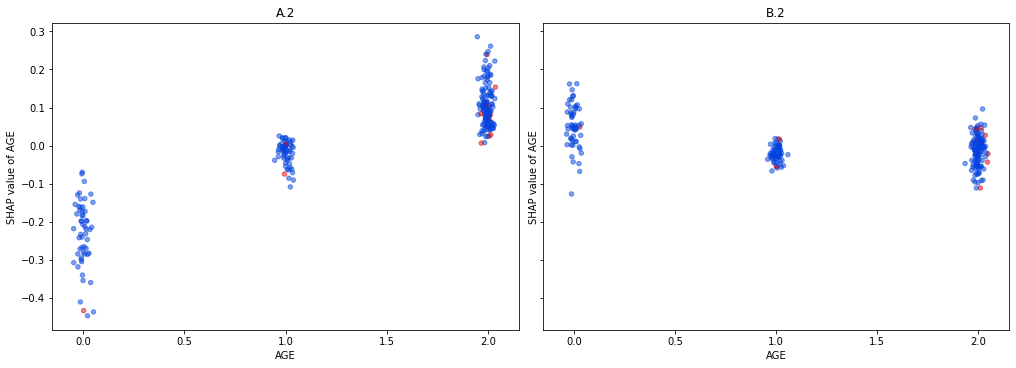

In [17]:
plot_next_feature()

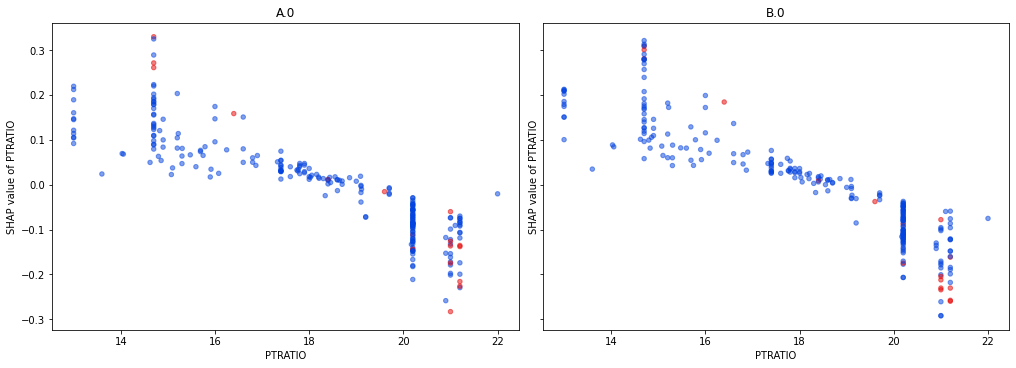

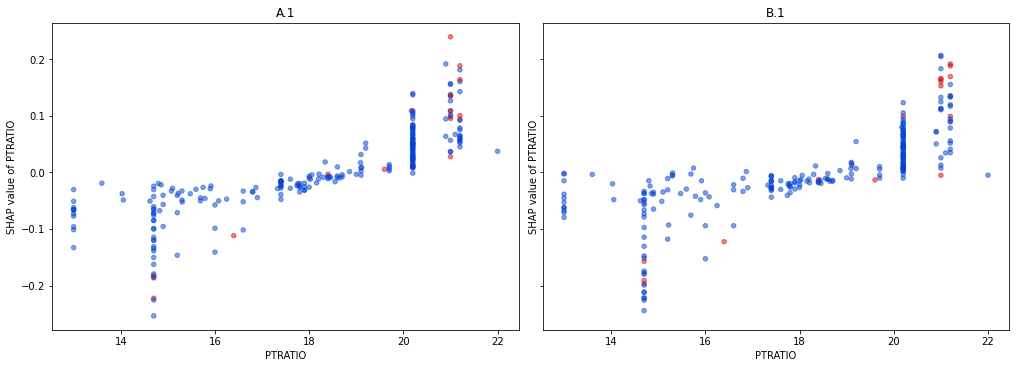

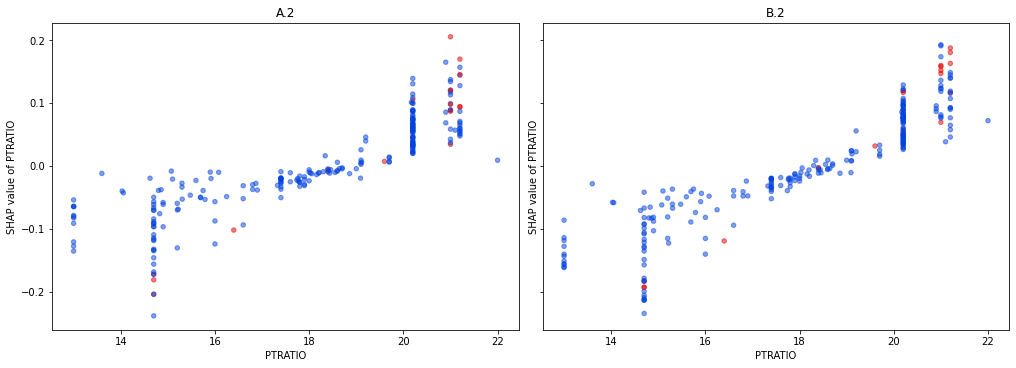

In [18]:
plot_next_feature()

# Difference Classifier SHAP Explanations

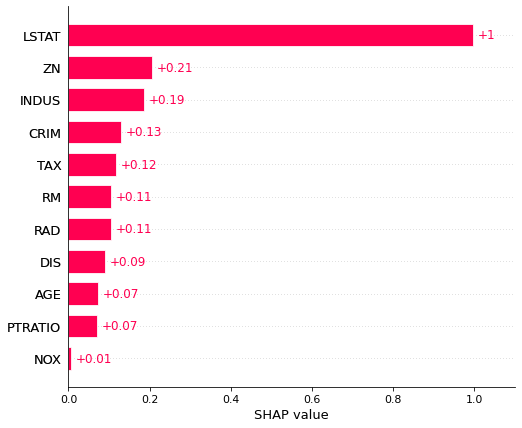

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [6]:
feature_order = feature_order[:-1]
global_feature_order = feature_order

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

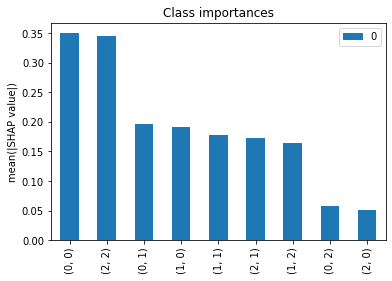

In [7]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [8]:
class_order = np.sort(class_order[:-2])

## Clustering of Class $(0,1)$ SHAP Values

In [22]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node RLR

In [23]:
node.class_counts, node.distance

((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 59.97803187230072)

In [24]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    76
 (1, 1)    58
 (2, 2)    21
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 36.72776810465103)

In [25]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    76
 (1, 1)    42
 (0, 1)    13
 (2, 1)     1
 dtype: int64,
 19.25760964540279)

In [26]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    76
 (1, 1)    15
 (0, 1)    13
 dtype: int64,
 12.019438010465088)

In [27]:
node.get_left().class_counts

(0, 0)    35
(0, 1)     2
dtype: int64

11.1 <= LSTAT <= 18.72
LSTAT <= 10.24 --> {'(1, 1)': 13}
LSTAT >= 19.17 --> {'(0, 0)': 13}


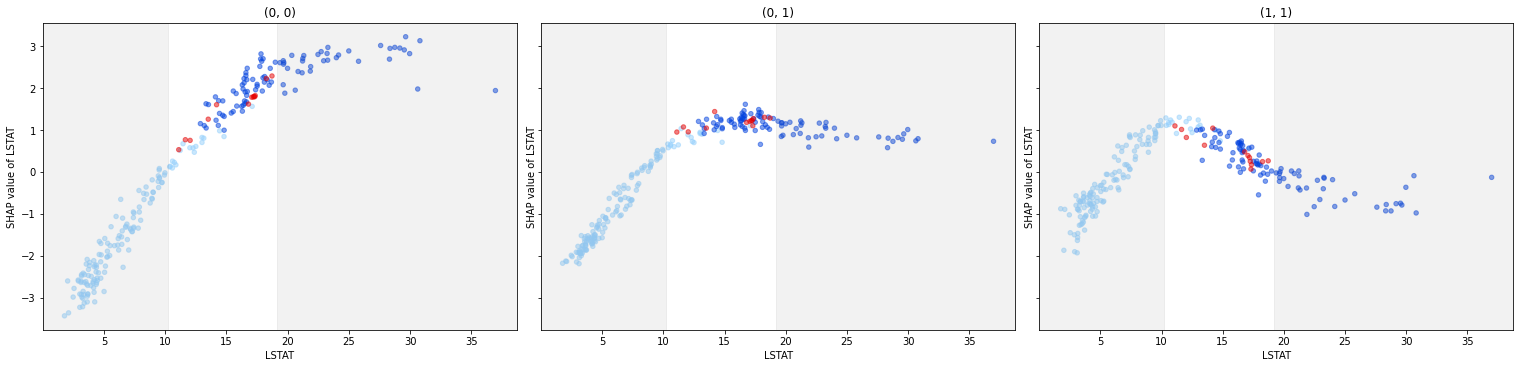

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 13}


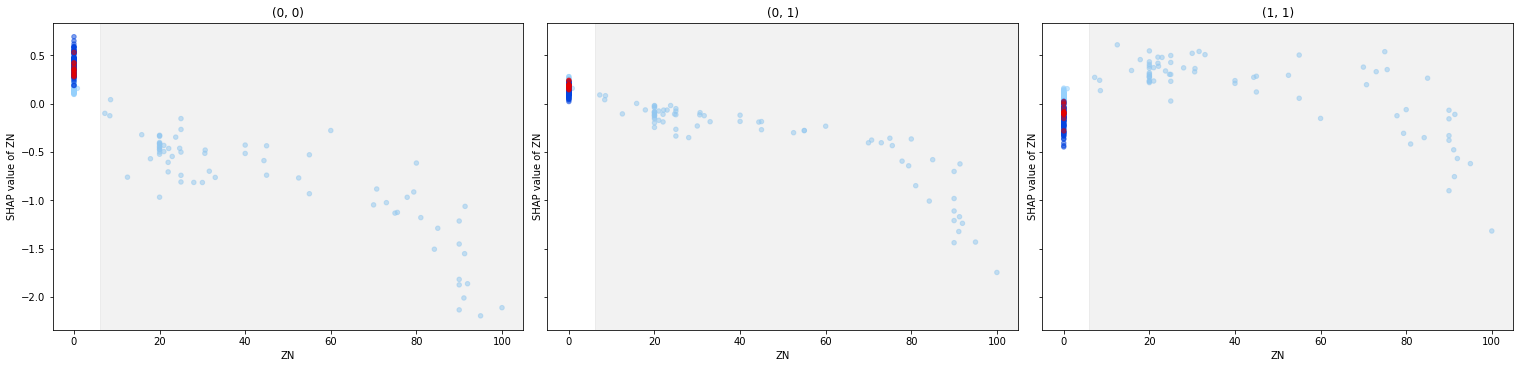

0.0456 <= CRIM <= 3.83684
CRIM >= 7.0 --> {'(0, 0)': 13}


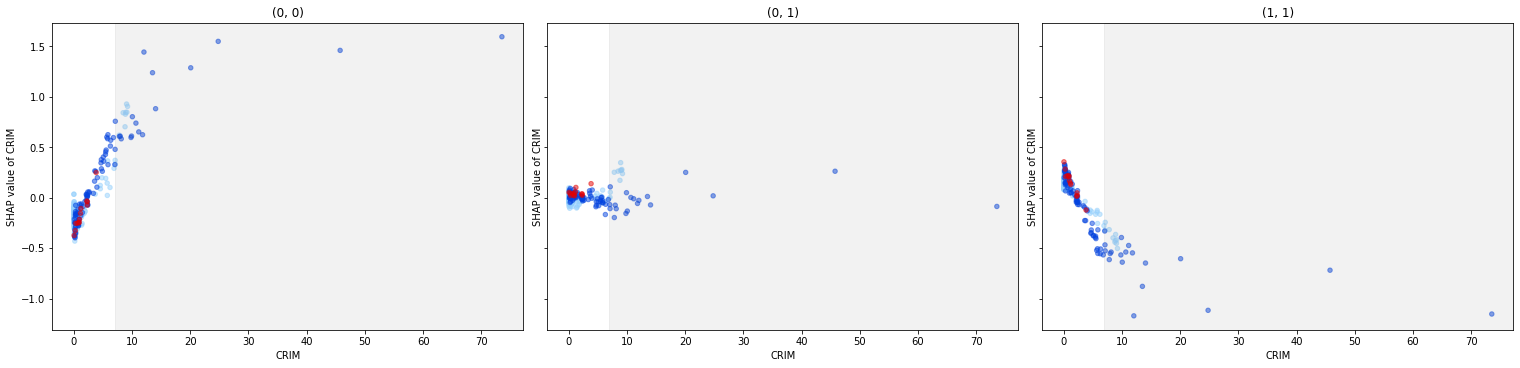

1.0 <= AGE
AGE <= 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}


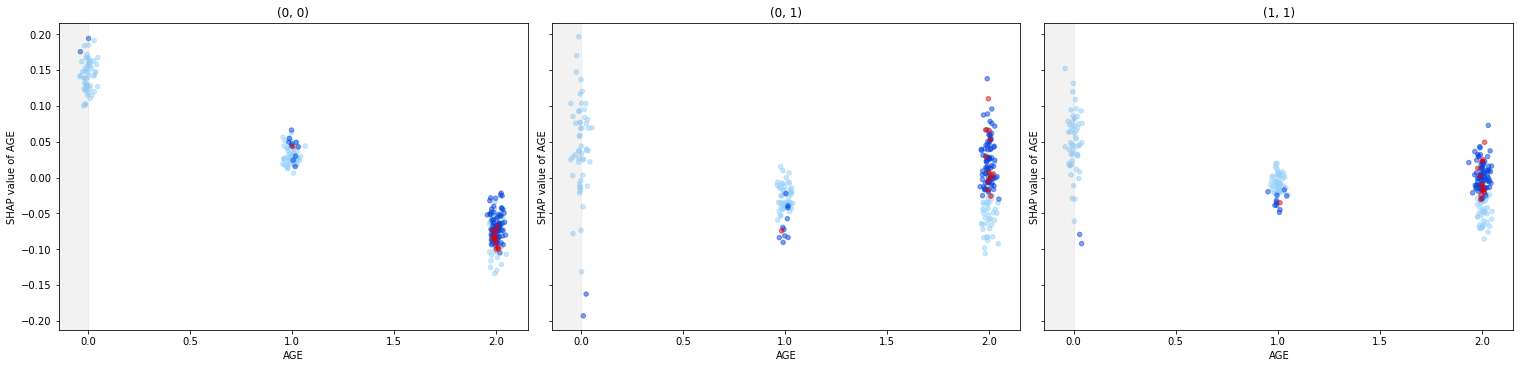

In [11]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

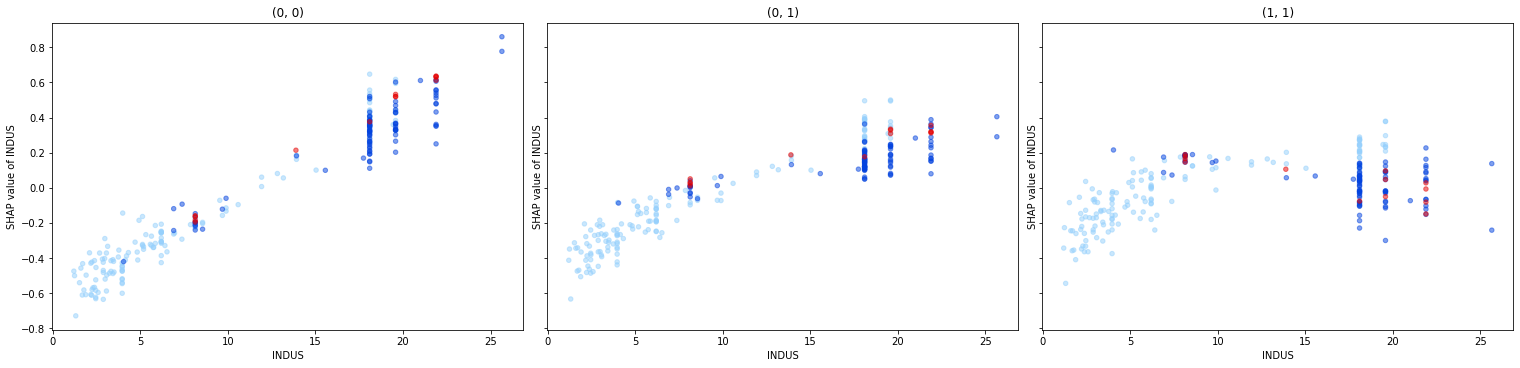

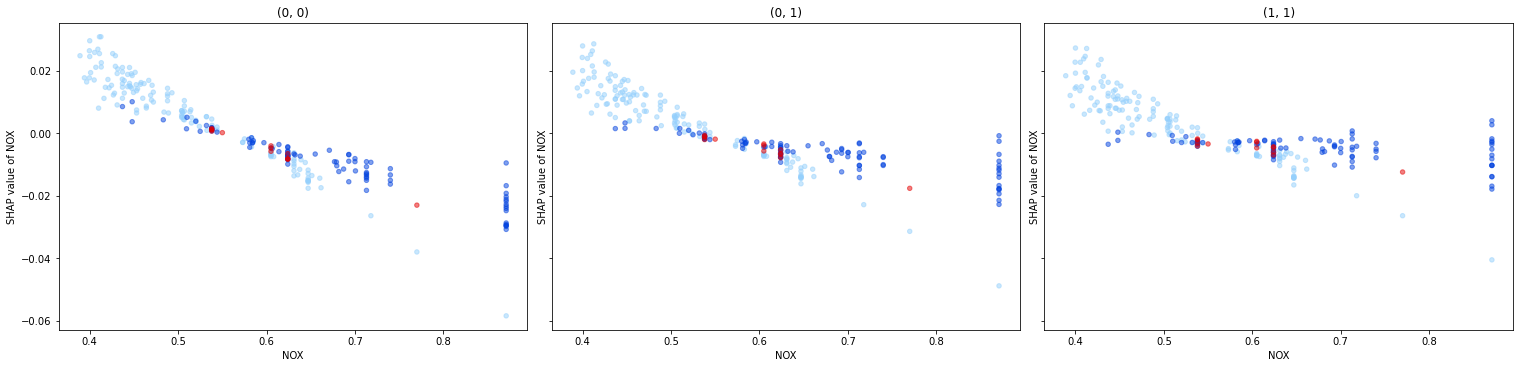

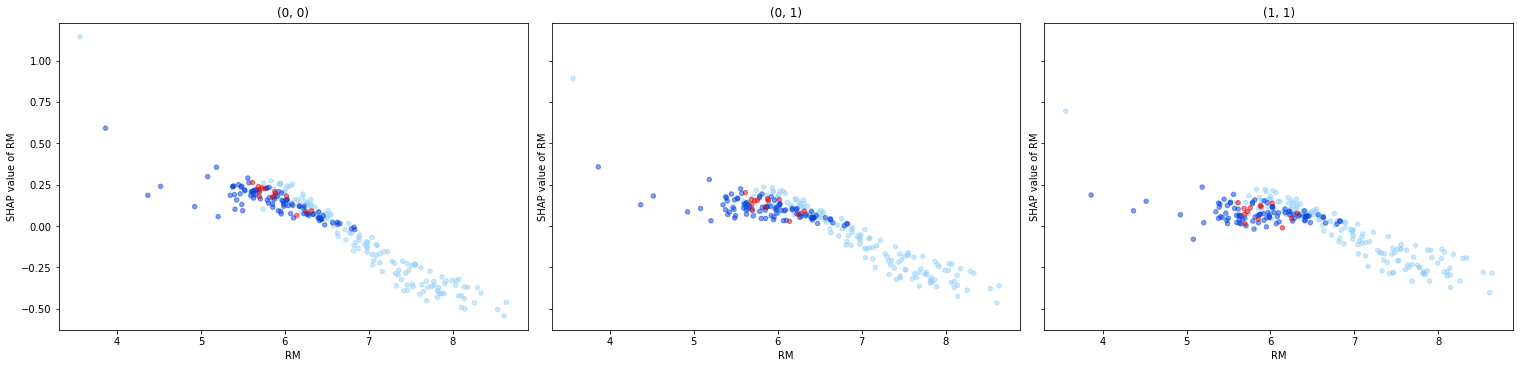

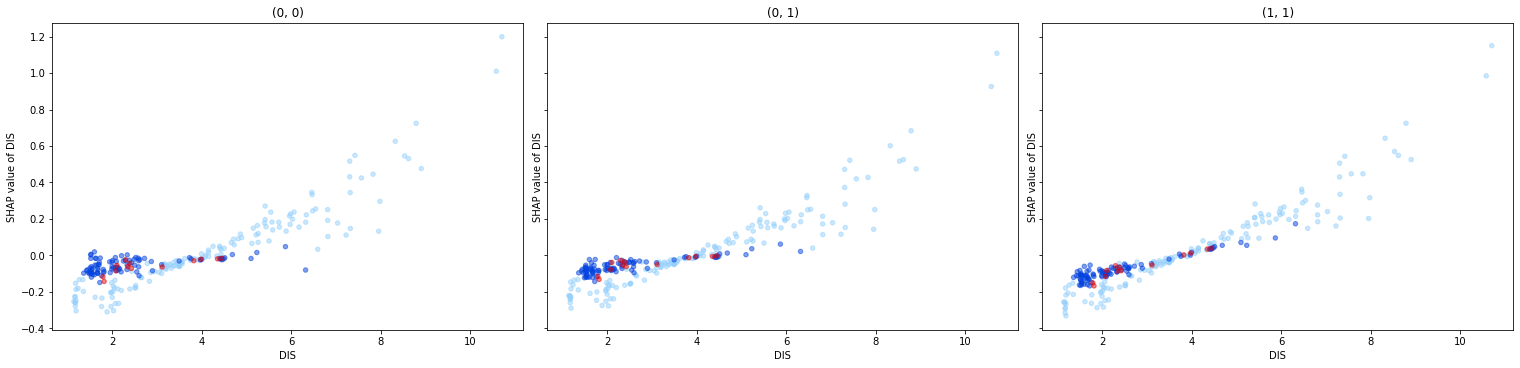

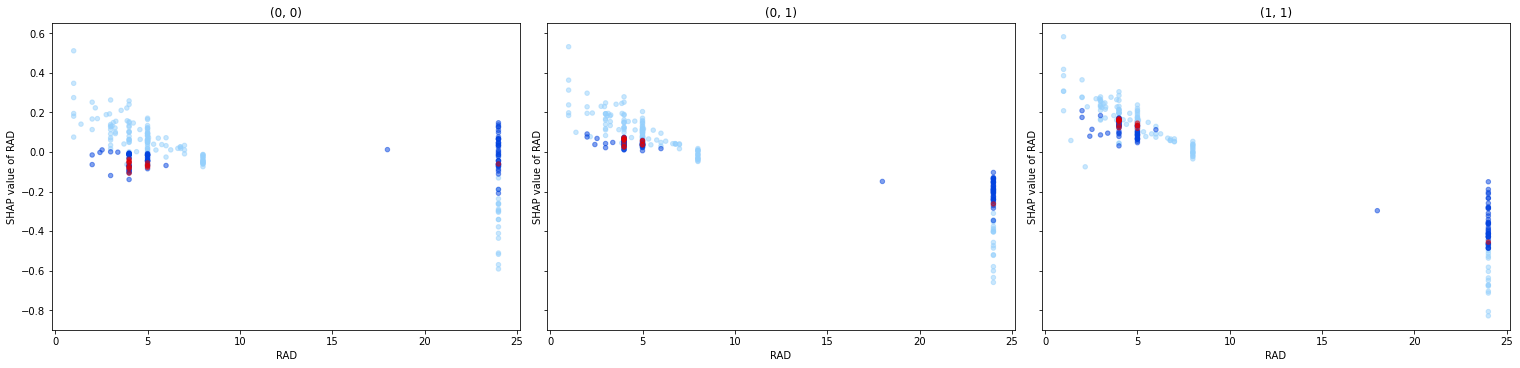

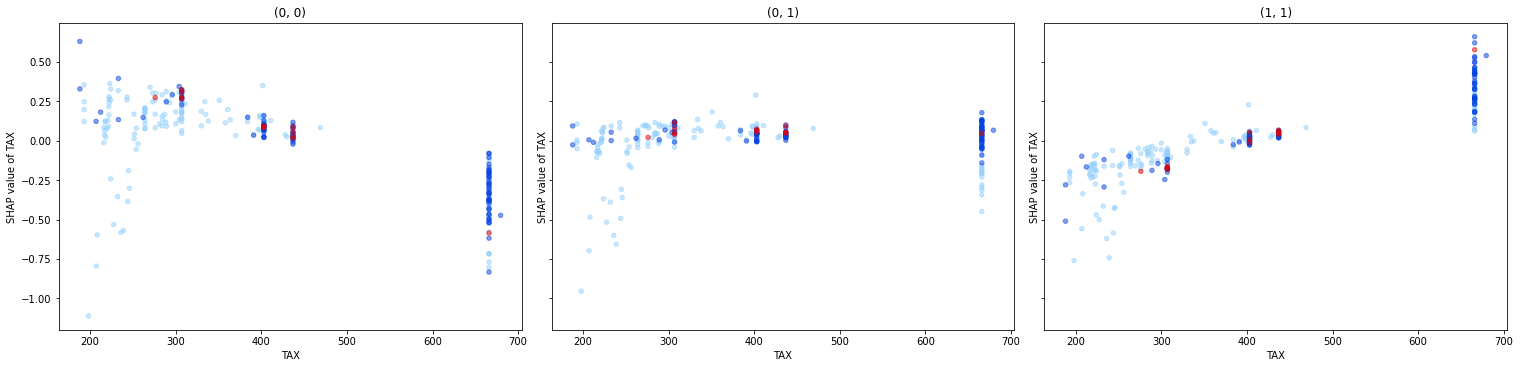

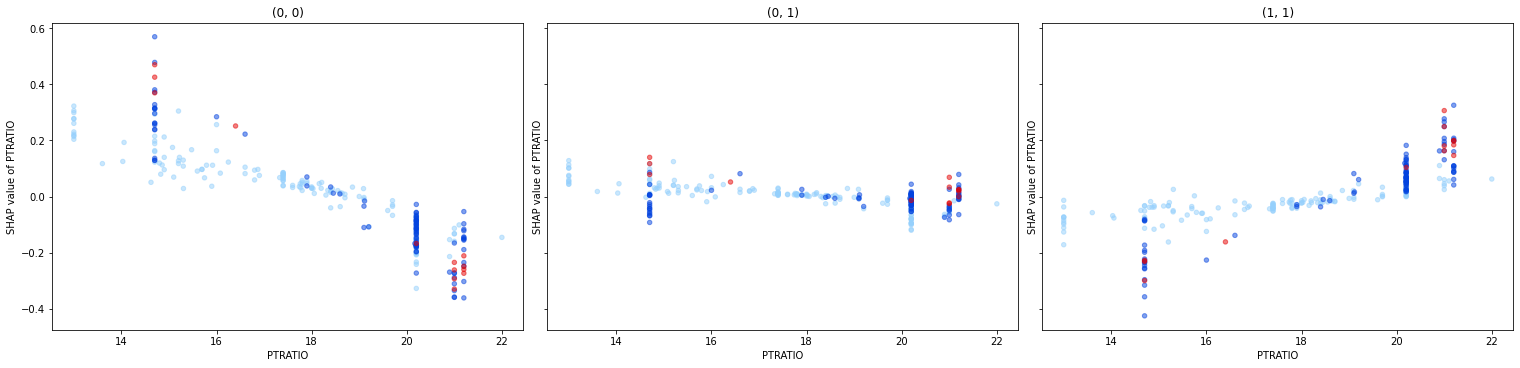

In [12]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

11.1 <= LSTAT <= 18.72
LSTAT <= 10.24 --> {'(1, 1)': 13}
LSTAT >= 19.17 --> {'(0, 0)': 13}


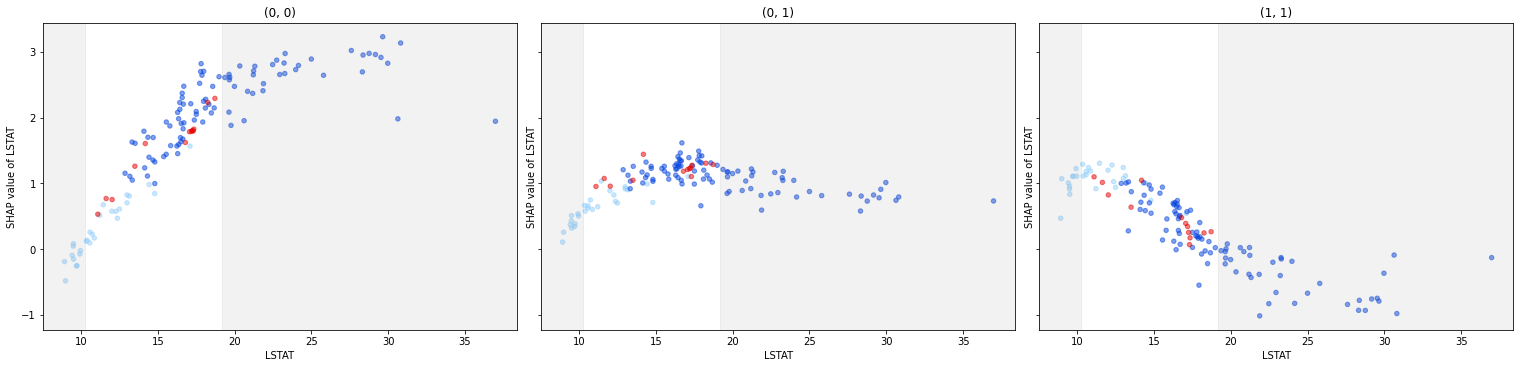

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 13}


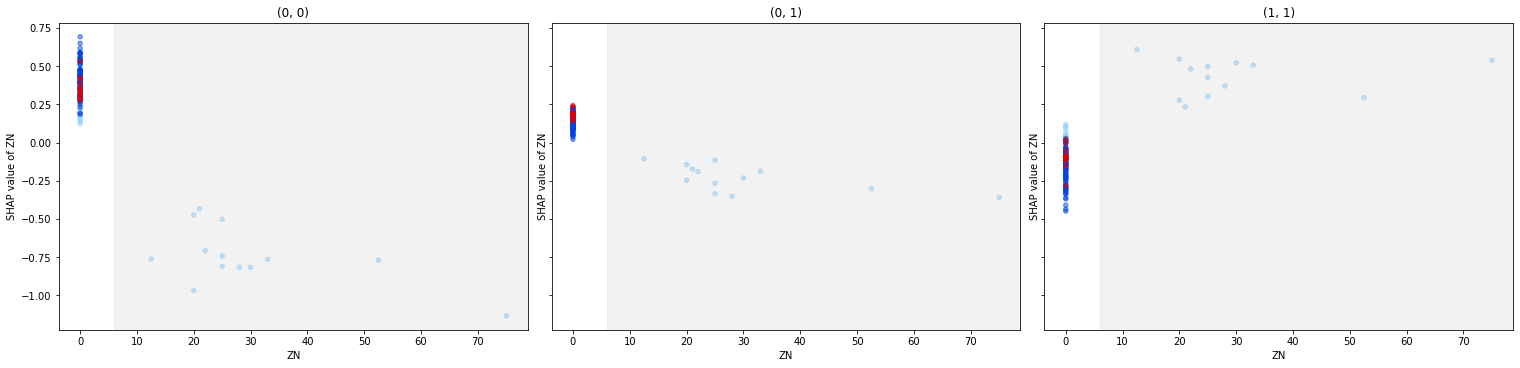

0.0456 <= CRIM <= 3.83684
CRIM >= 7.0 --> {'(0, 0)': 13}


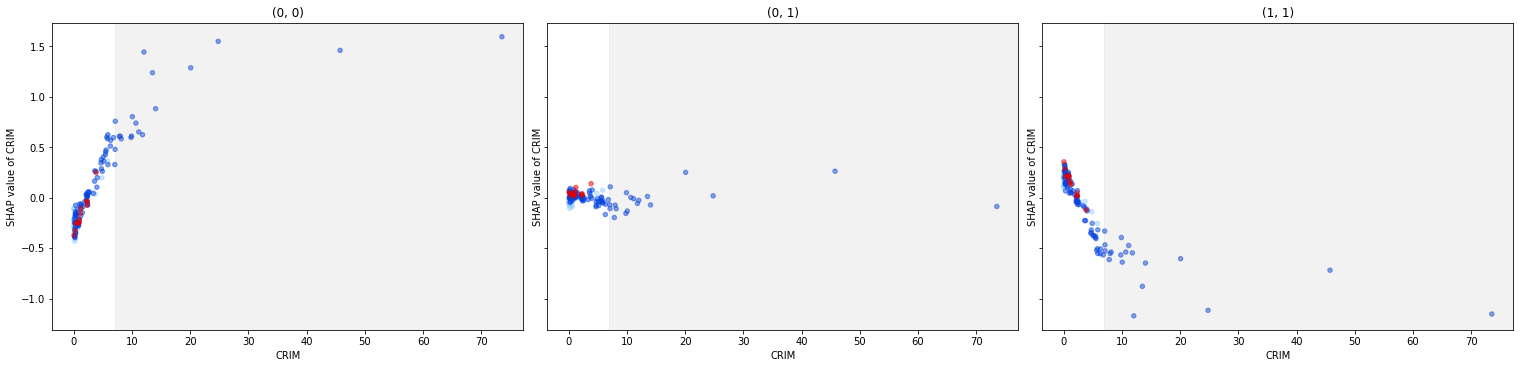

In [28]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

I doubt that the second global explanation is a good one, because most instances have ZN=0. Checking these instances, we can see that there are many with ZN=0 which are in the LSTAT range of differences:

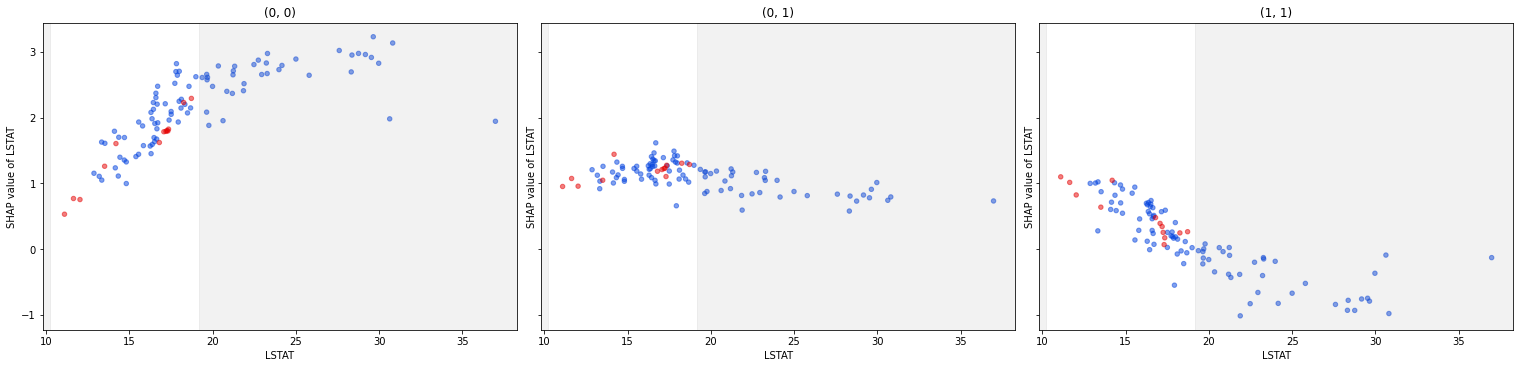

In [15]:
part = node.filter(node.shap_values[:, 'ZN'].data < 1)
part.plot_feature('LSTAT', alpha=0.5)

CRIM is also not a good explanation, because most instances are below the upper counterfactual.

### Node RLRL

In [29]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    35
 (0, 1)     2
 dtype: int64,
 4.0841830650527315)

In [30]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    19
 (0, 1)     2
 dtype: int64,
 2.604181120119307)

In [31]:
node.get_left().class_counts

(0, 1)    2
(0, 0)    1
dtype: int64

18.25726553185902 <= LSTAT <= 18.72
LSTAT <= 16.39 --> {'(1, 1)': 2}
LSTAT >= 18.95 --> {'(0, 0)': 2}


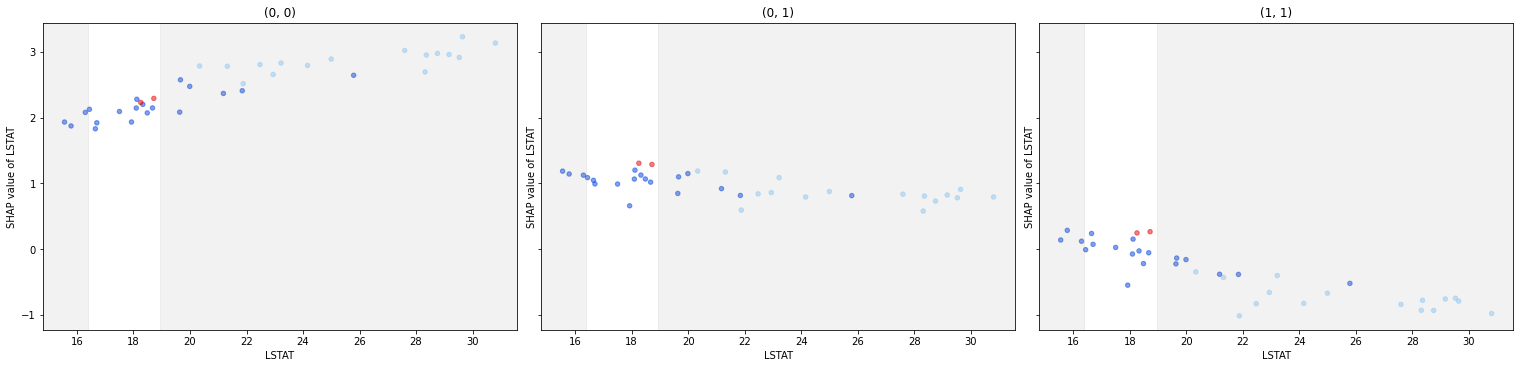

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 2}


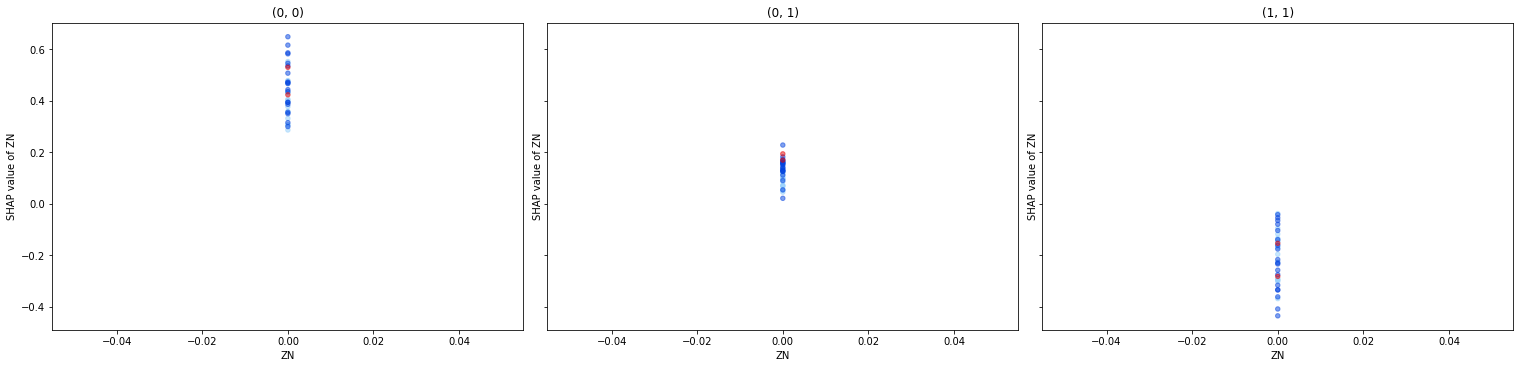

8.14 <= INDUS <= 8.14
INDUS >= 10.64 --> {'(0, 0)': 2}


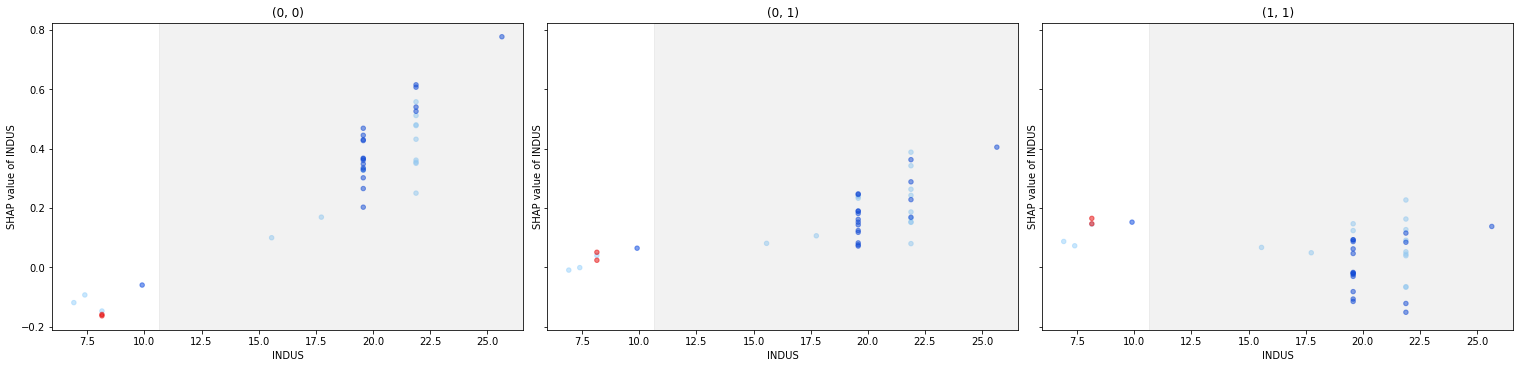

In [20]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

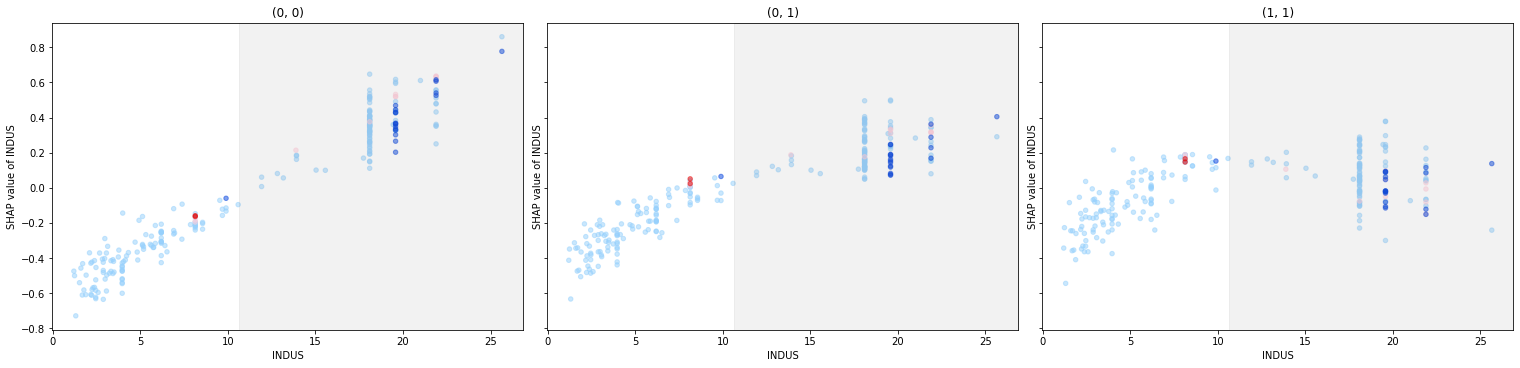

In [21]:
node.root.plot_feature('INDUS', focus=node, alpha=0.5)

I already argued, that ZN alone is not a sufficient explanation. But the third most important feature INDUS and its low upper counterfactual provides a good explanation for these two instances.

### Node RLRRR

In [32]:
node = node.parent.parent.get_right()
node.class_counts, node.distance

((0, 0)    41
 (1, 1)    15
 (0, 1)    11
 dtype: int64,
 8.94024060229284)

In [33]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    15
 (0, 1)    11
 (0, 0)    11
 dtype: int64,
 5.1794988864017935)

In [34]:
node.get_left().class_counts

(0, 0)    7
(1, 1)    3
(0, 1)    1
dtype: int64

11.1 <= LSTAT <= 17.348228318163887
LSTAT <= 10.24 --> {'(1, 1)': 11}
LSTAT >= 19.17 --> {'(0, 0)': 11}


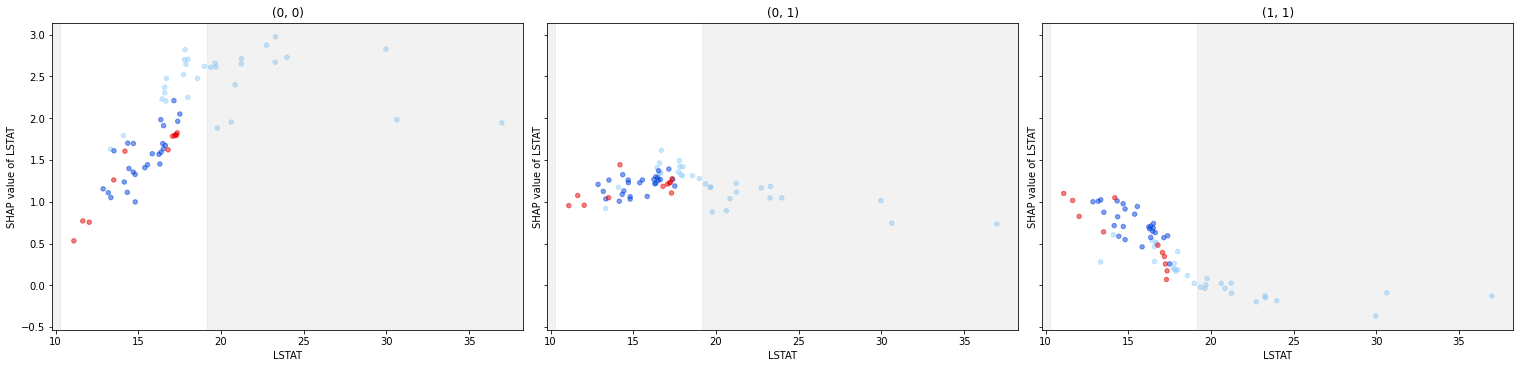

8.14 <= INDUS <= 21.89
INDUS <= 7.25 --> {'(1, 1)': 11}


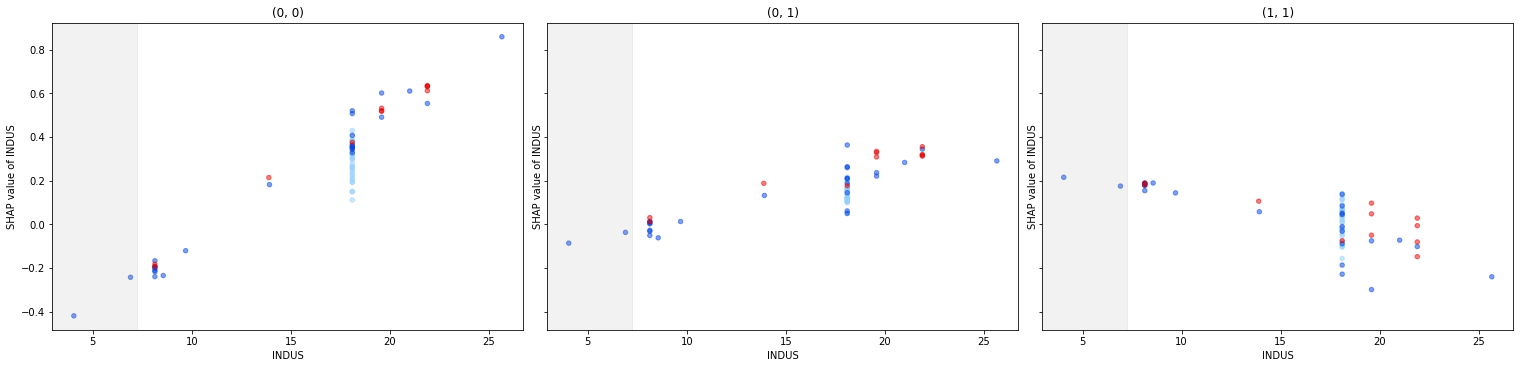

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 11}


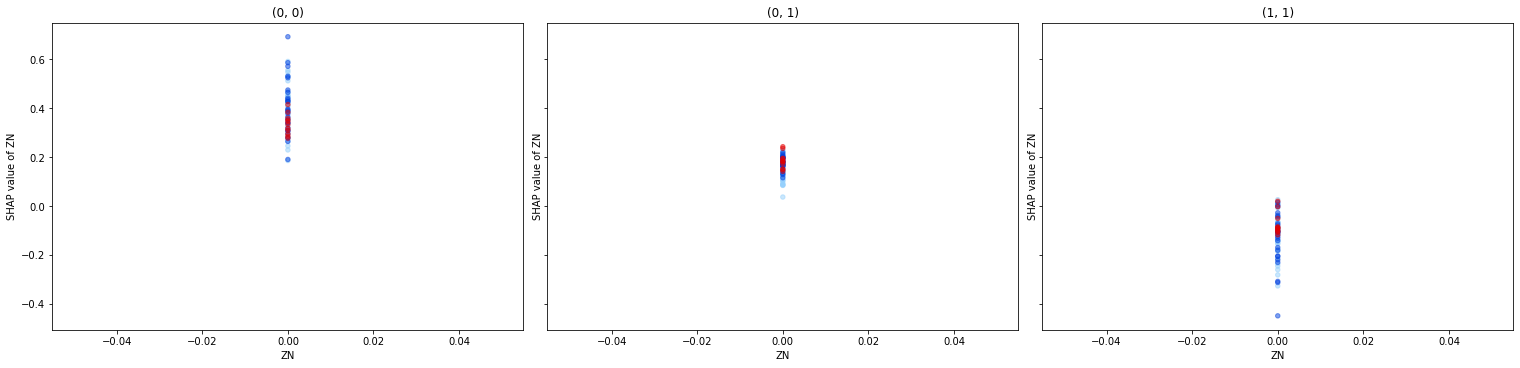

In [35]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

The explanations are not much different from the global explanations and the cluster difference is still quite high compared to the last cluster's explanation. I will try with more precise explanations.

### Node RLRRRL

In [36]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    7
 (1, 1)    3
 (0, 1)    1
 dtype: int64,
 2.273180061554279)

Just a single instance left to explain

14.19 <= LSTAT <= 14.19
LSTAT <= 13.9 --> {'(1, 1)': 1}
LSTAT >= 16.13 --> {'(0, 0)': 1}


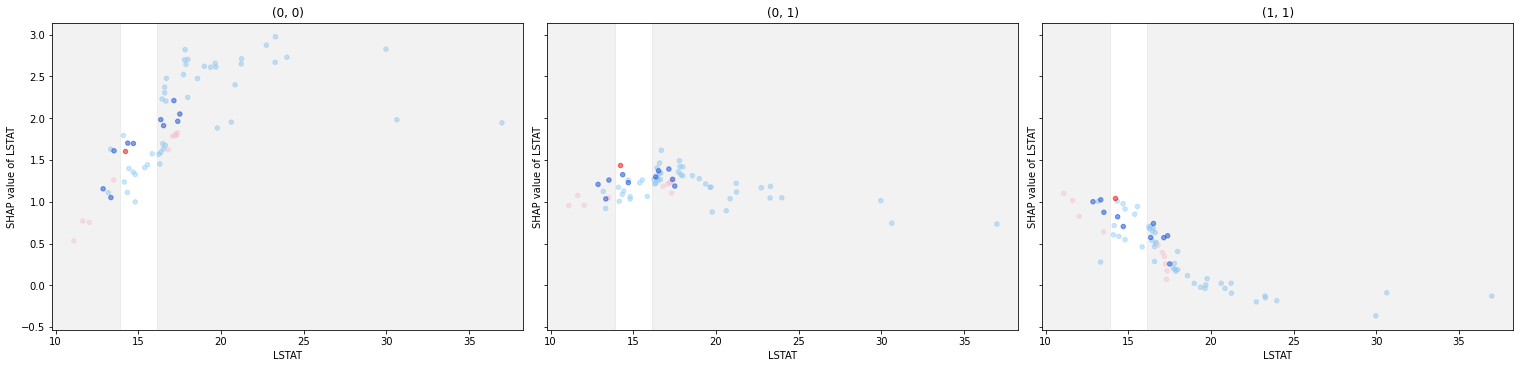

666.0 <= TAX <= 666.0
TAX <= 499.0 --> {'(0, 0)': 1}


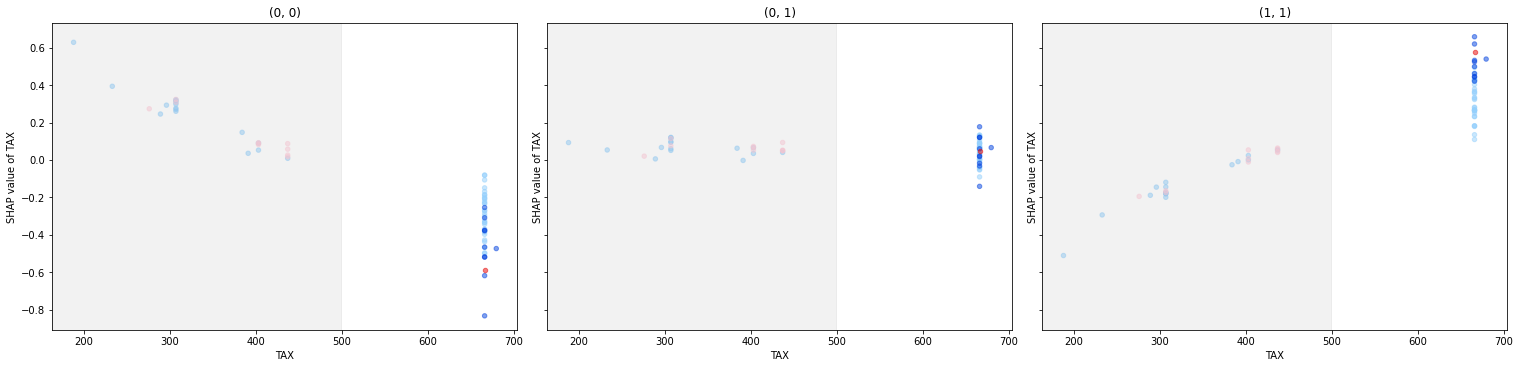

In [37]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

This instance has a particularly high TAX value. If it was 499 or lower, the prediction would flip.

### Node RLRRRR

In [38]:
node = node.parent.get_right()
node.class_counts, node.distance

((1, 1)    12
 (0, 1)    10
 (0, 0)     4
 dtype: int64,
 3.6105211202572907)

In [39]:
node.get_left().class_counts

(0, 1)    3
(0, 0)    2
dtype: int64

11.1 <= LSTAT <= 17.348228318163887
LSTAT <= 10.24 --> {'(1, 1)': 10}
LSTAT >= 19.17 --> {'(0, 0)': 10}


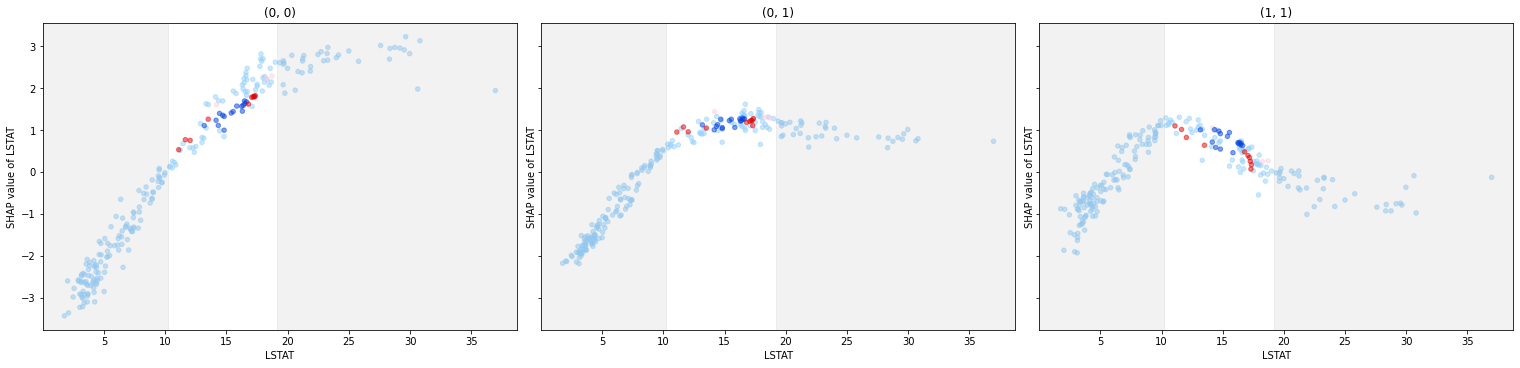

8.14 <= INDUS <= 21.89
INDUS <= 7.25 --> {'(1, 1)': 10}


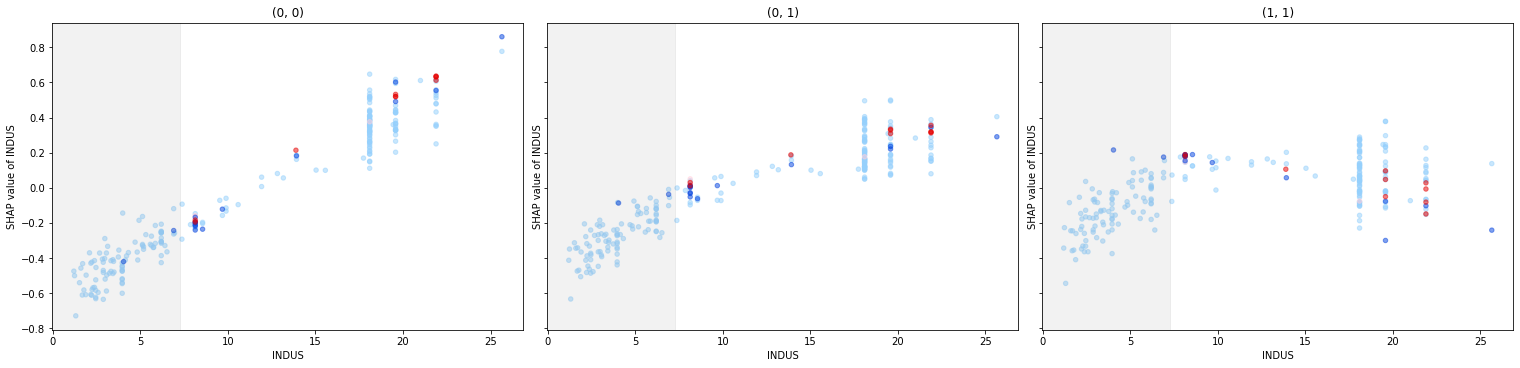

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 10}


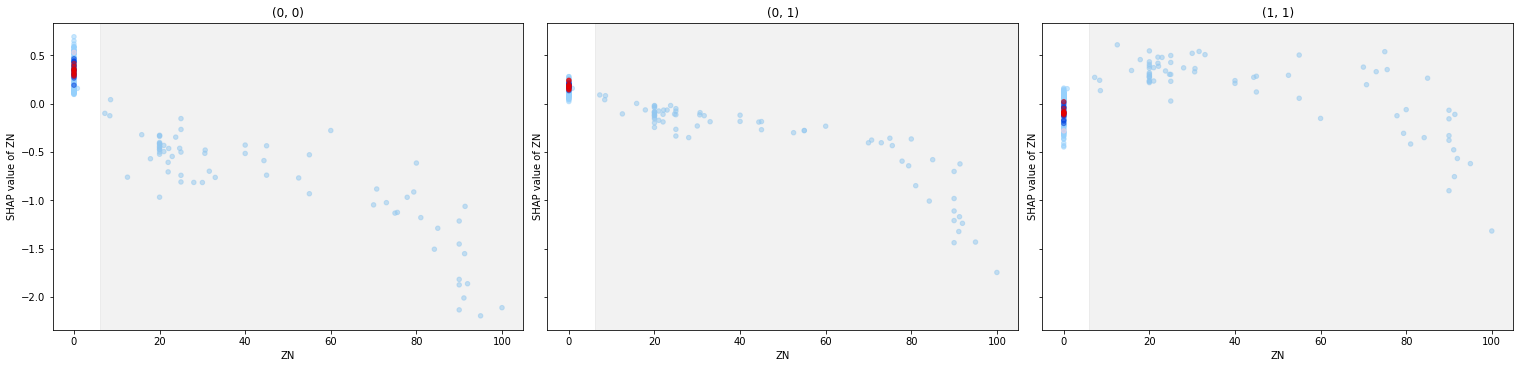

In [40]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

Interestingly, INDUS now has a counterfactual explanation, but it still covers the majority of the data.

### Node RLRRRRL

In [41]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    3
 (0, 0)    2
 dtype: int64,
 1.142040532832735)

In [42]:
node.get_left().class_counts

(0, 1)    3
dtype: int64

11.1 <= LSTAT <= 12.03
LSTAT <= 10.24 --> {'(1, 1)': 3}
LSTAT >= 13.14 --> {'(0, 0)': 3}


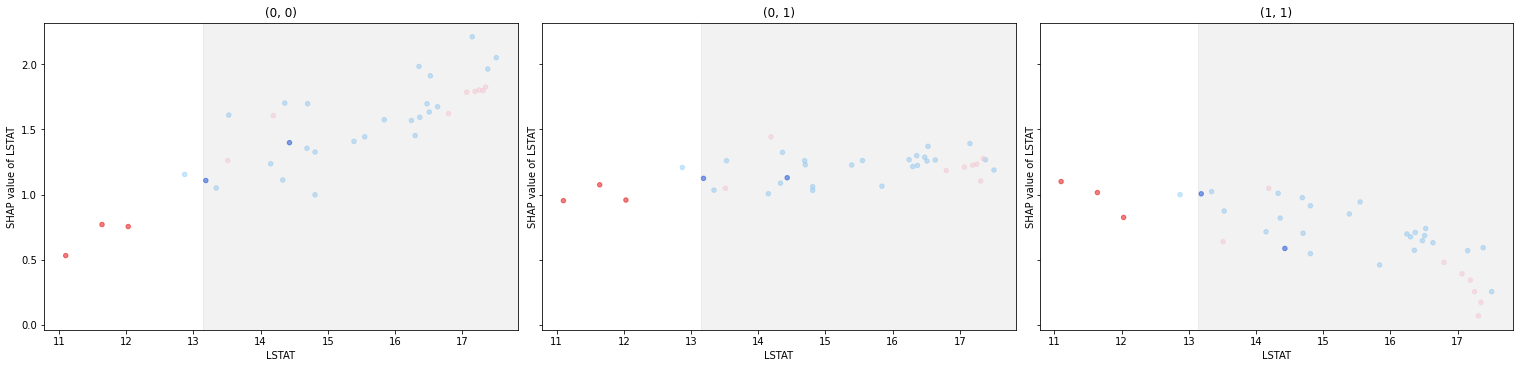

19.58 <= INDUS <= 19.58
INDUS <= 12.03 --> {'(1, 1)': 3}


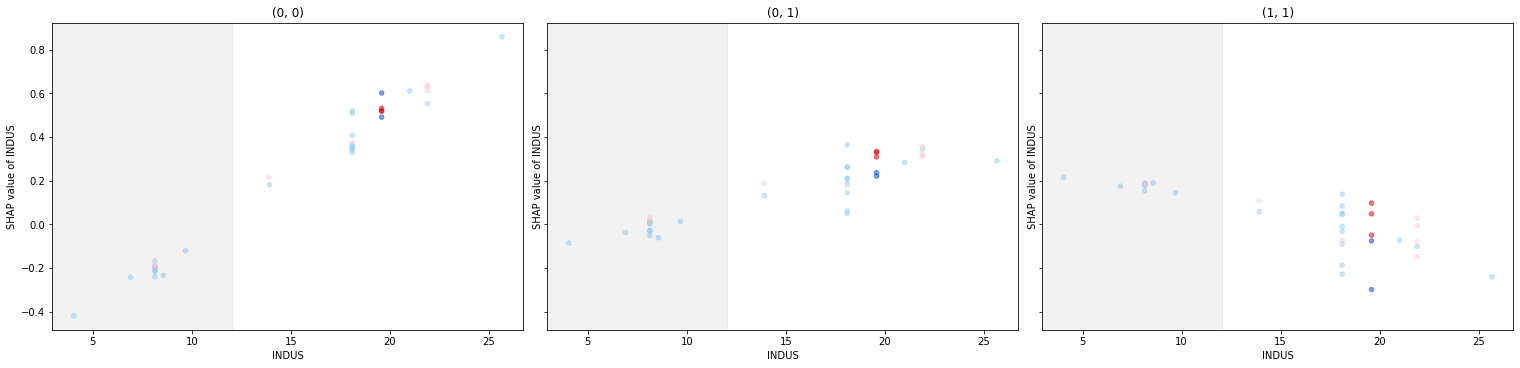

In [43]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

These instances have a high INDUS value. If it was 12.03 or lower, the prediction would flip to $(1,1)$.

### Node RLRRRRR

In [44]:
node = node.parent.get_right()
node.class_counts, node.distance

((1, 1)    12
 (0, 1)     7
 (0, 0)     2
 dtype: int64,
 2.8788266439832437)

In [45]:
node.get_left().class_counts

(1, 1)    11
(0, 1)     2
dtype: int64

13.51 <= LSTAT <= 17.348228318163887
LSTAT <= 13.14 --> {'(1, 1)': 7}
LSTAT >= 19.17 --> {'(0, 0)': 7}


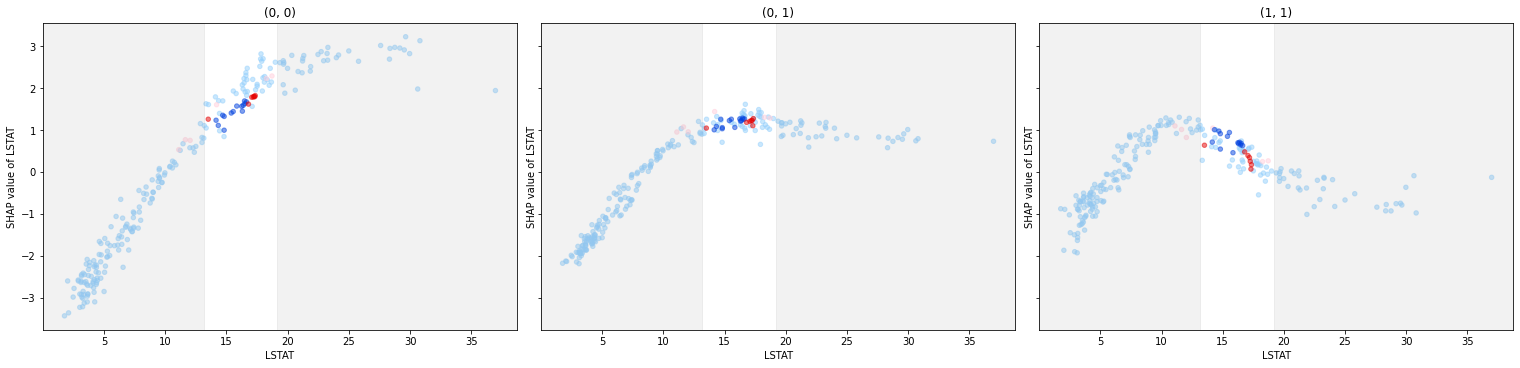

8.14 <= INDUS <= 21.89
INDUS <= 7.25 --> {'(1, 1)': 7}


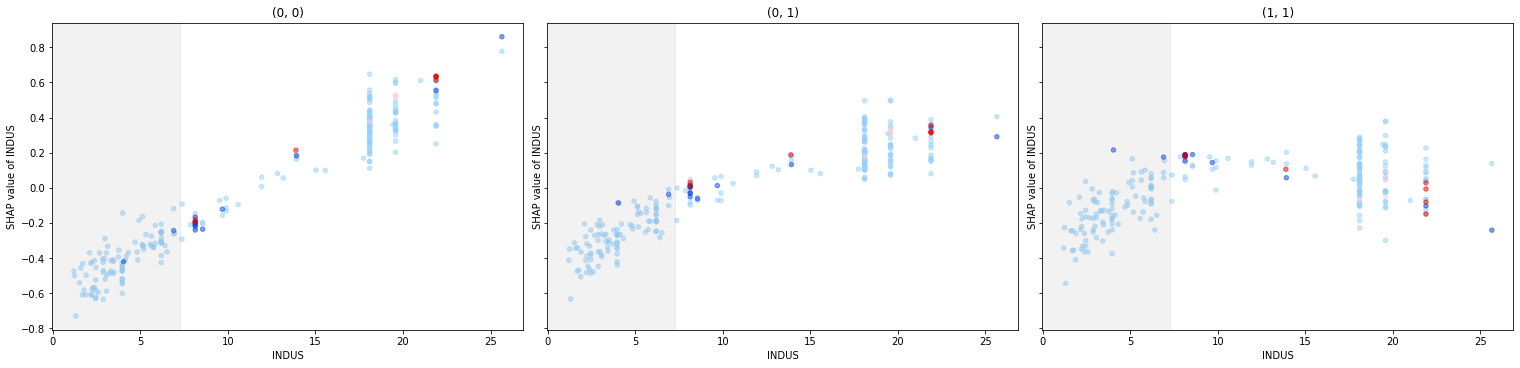

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 7}


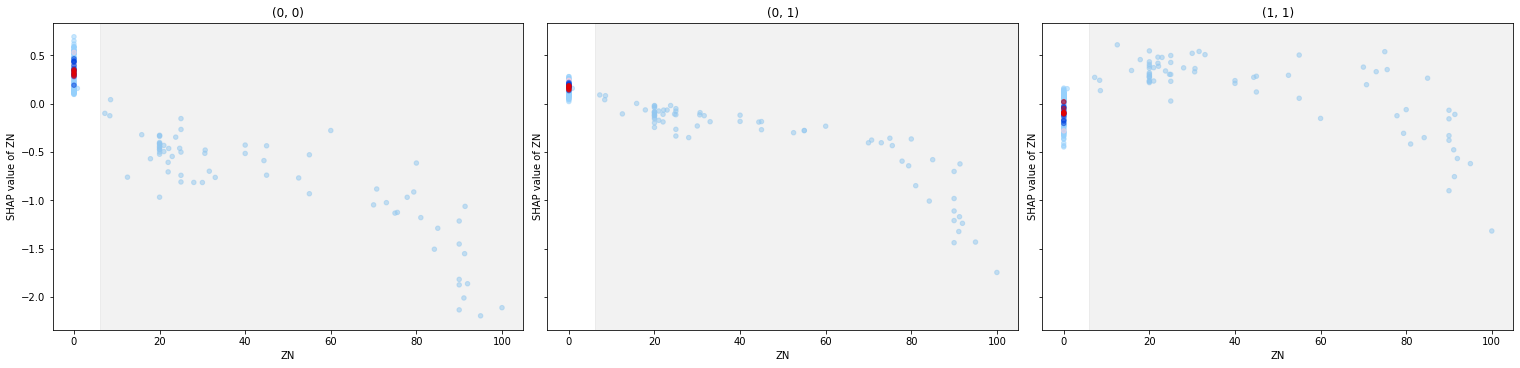

In [46]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

INDUS does not offer a satisfying counterfactual explanation, which might be due to the high range of INDUS values present in instances classified differently. I will investigate on a lower hierarchy level.

### Node RLRRRRRL

In [47]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    11
 (0, 1)     2
 dtype: int64,
 1.0960157312448422)

In [48]:
node.get_left().class_counts

(1, 1)    6
(0, 1)    2
dtype: int64

16.79698376047181 <= LSTAT <= 17.066695066513088
LSTAT <= 16.63 --> {'(1, 1)': 2}
LSTAT >= 19.17 --> {'(0, 0)': 2}


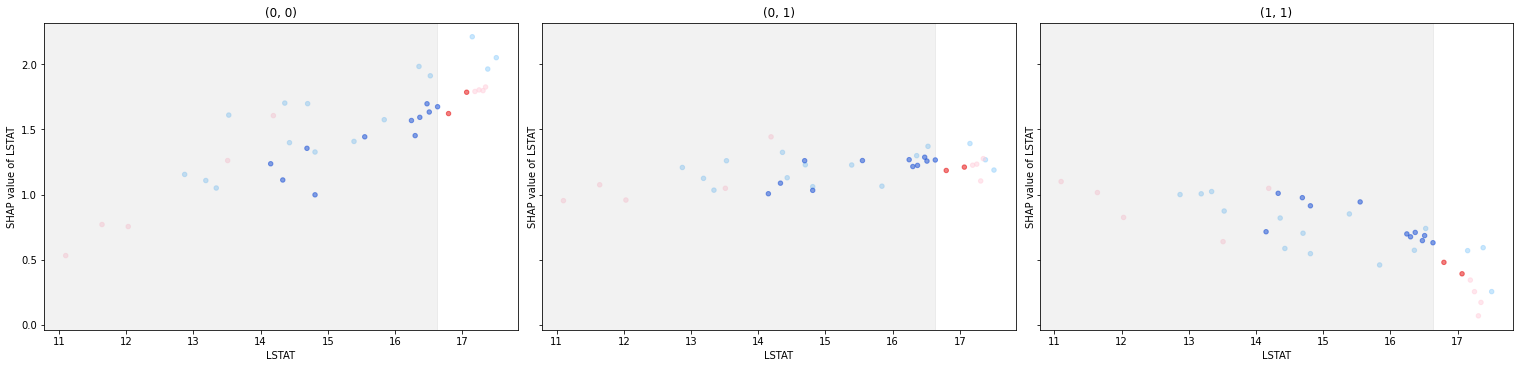

ZN <= 0.0
ZN >= 1.0 --> {'(1, 1)': 2}


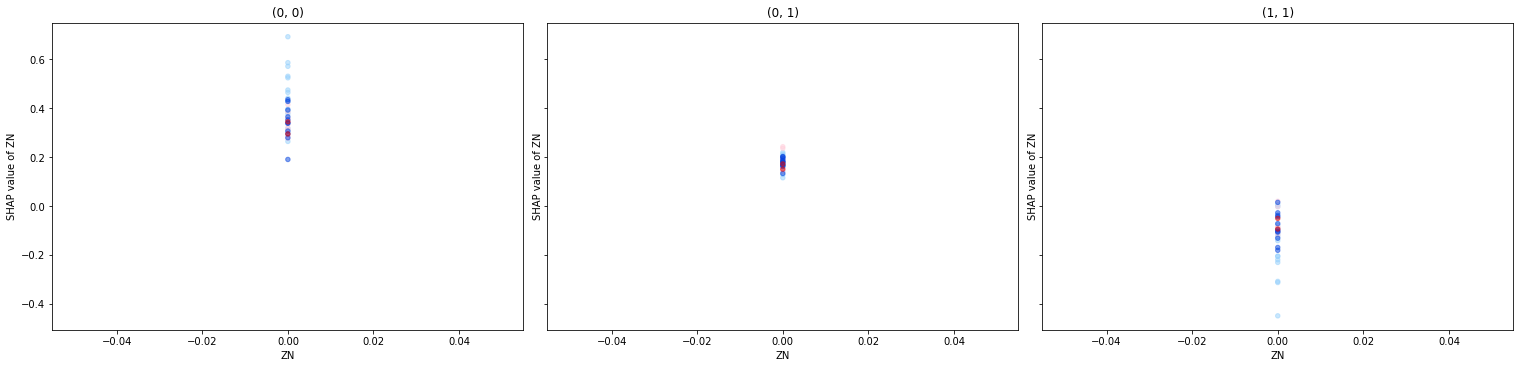

0.8890745687954446 <= CRIM <= 0.9110390848154124
CRIM <= 0.0 --> {'(1, 1)': 2}
CRIM >= 4.0 --> {'(0, 0)': 2}


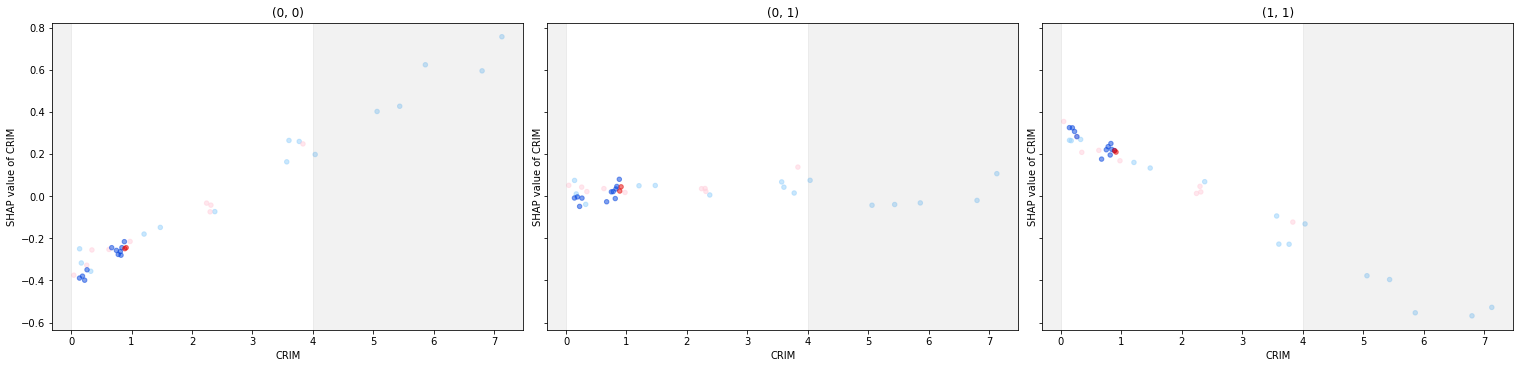

In [49]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

For these instances, the counterfactual for ZN is much lower and the lowest possible CRIM value actually flips the prediction to $(1,1)$.

### Node RLRRRRRR

In [50]:
node = node.parent.get_right()
node.class_counts, node.distance

((0, 1)    5
 (0, 0)    2
 (1, 1)    1
 dtype: int64,
 1.4070206110764154)

In [51]:
node.get_left().class_counts

(0, 1)    4
(1, 1)    1
dtype: int64

13.51 <= LSTAT <= 17.348228318163887
LSTAT <= 13.14 --> {'(1, 1)': 5}
LSTAT >= 18.14 --> {'(0, 0)': 5}


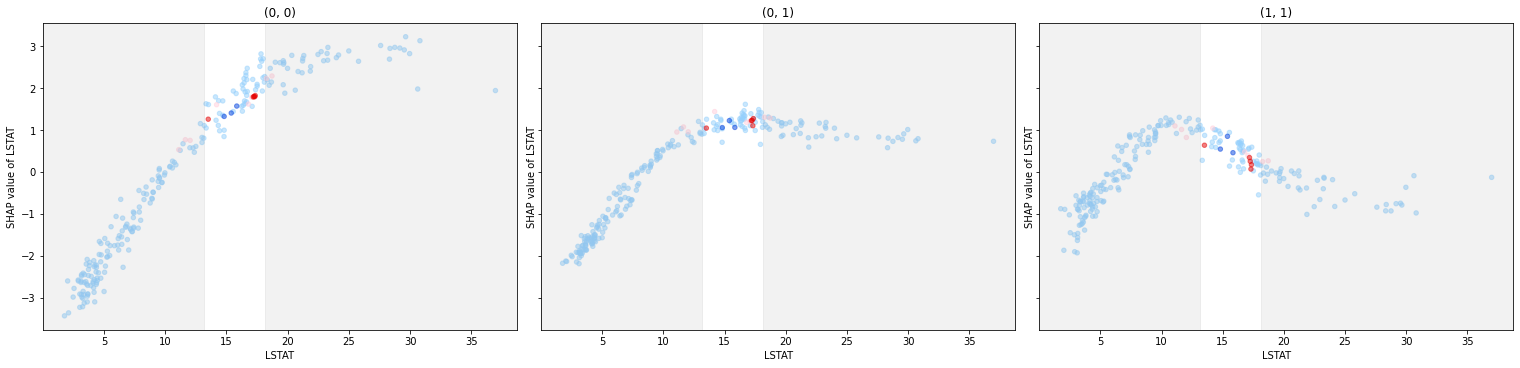

13.89 <= INDUS <= 21.89
INDUS <= 11.88 --> {'(1, 1)': 5}


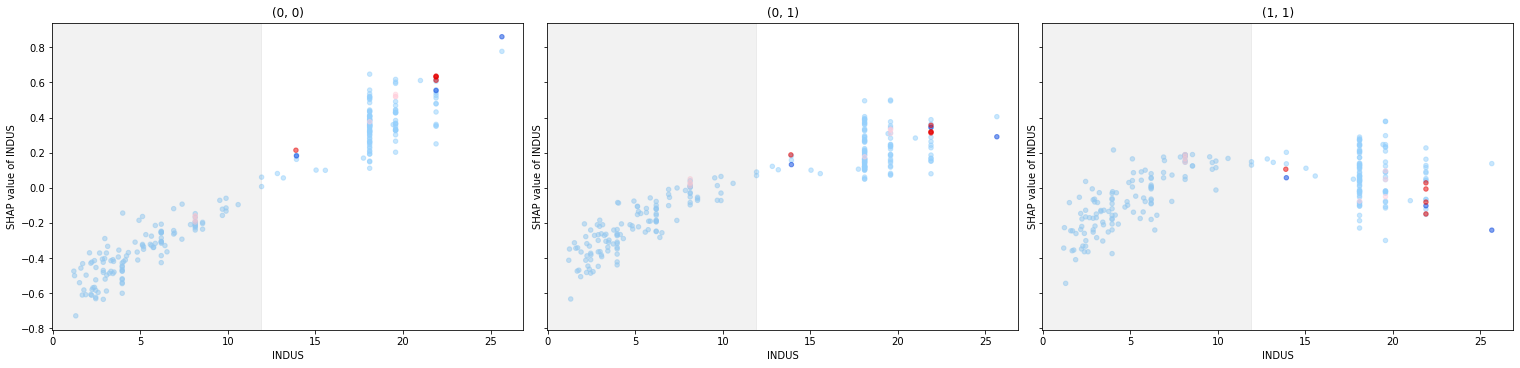

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 5}


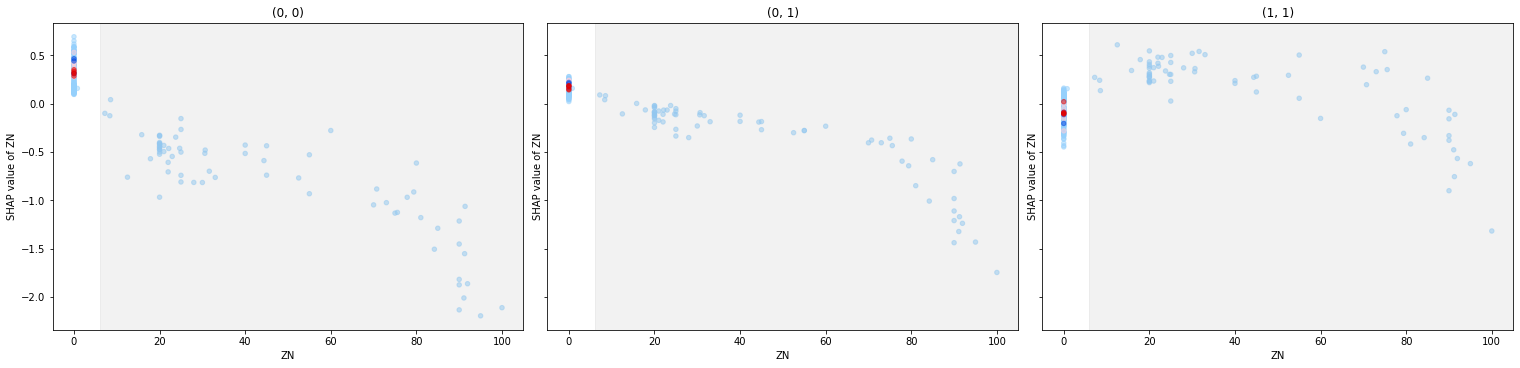

In [52]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

INDUS is ranked as the second most important feature in this cluster. But still it seems to have structure: some with lower values and some with higher.

### Node RLRRRRRRL

In [53]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    4
 (1, 1)    1
 dtype: int64,
 0.90652780777958)

17.19 <= LSTAT <= 17.348228318163887
LSTAT <= 14.9 --> {'(1, 1)': 4}
LSTAT >= 18.14 --> {'(0, 0)': 4}


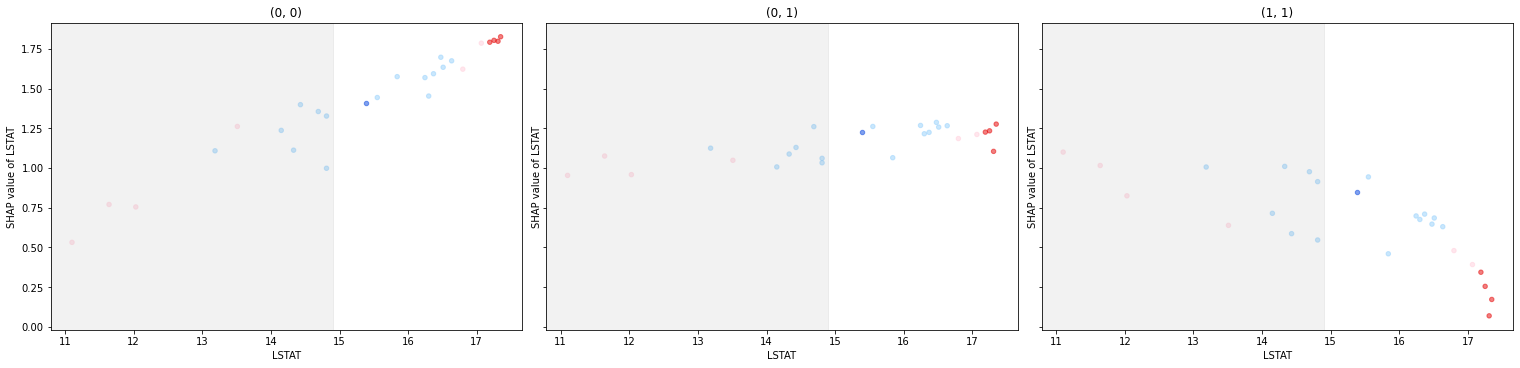

21.89 <= INDUS <= 21.89
INDUS <= 11.88 --> {'(1, 1)': 4}


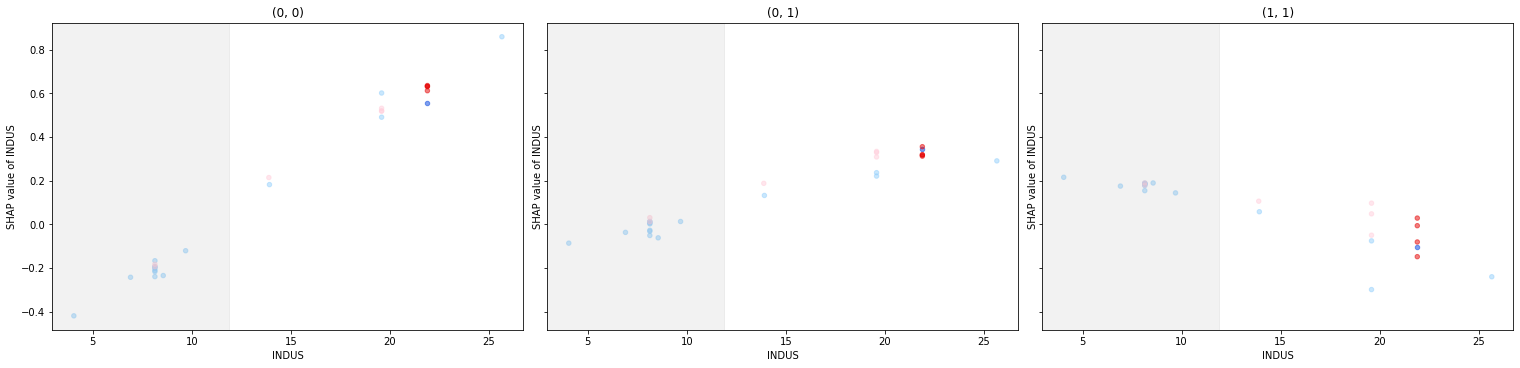

In [57]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

Interestingly, the children are split by INDUS. This cluster has the same counterfactual as the parent cluster.

### Node RLRRRRRRR

In [58]:
node = node.parent.get_right()
node.class_counts, node.distance

((0, 0)    2
 (0, 1)    1
 dtype: int64,
 1.31415055354475)

13.51 <= LSTAT <= 13.51
LSTAT <= 13.14 --> {'(1, 1)': 1}
LSTAT >= 14.1 --> {'(0, 0)': 1}


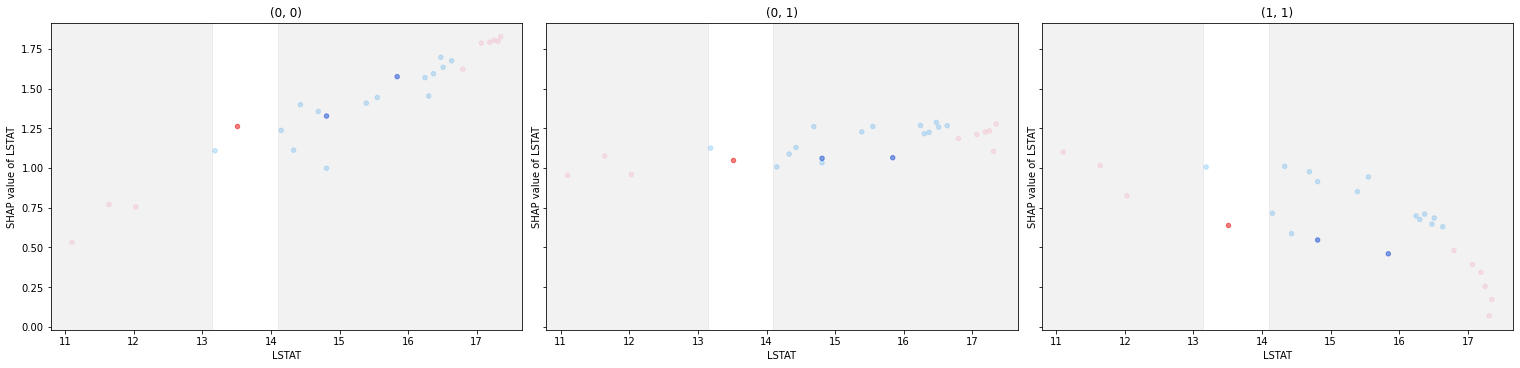

13.89 <= INDUS <= 13.89
INDUS <= 12.37 --> {'(1, 1)': 1}
INDUS >= 16.67 --> {'(0, 0)': 1}


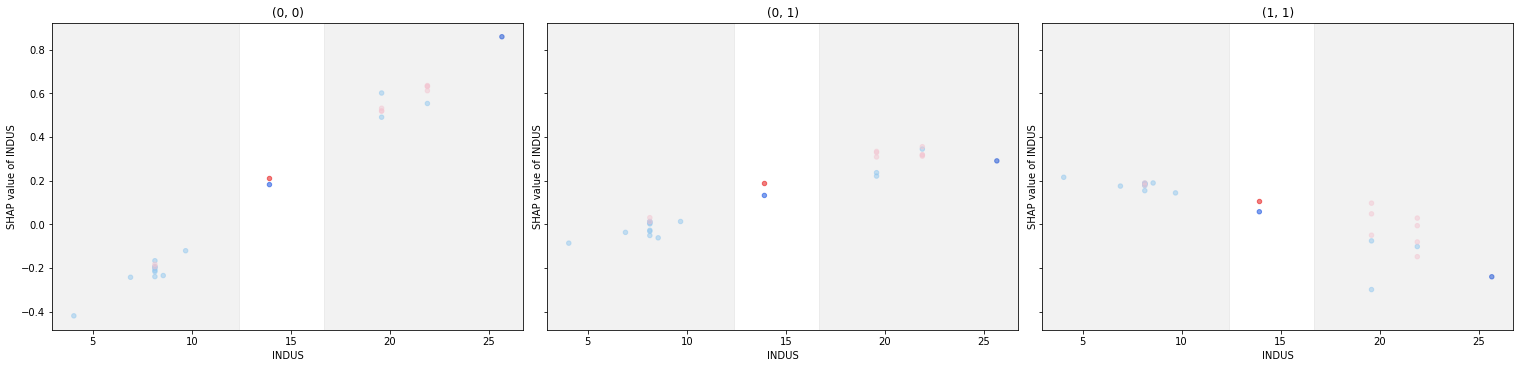

In [59]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

For this instance, there is even an upper counterfactual.

## Clustering of Class $(1,2)$ SHAP Values

In [121]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(1, 2)', ['(1, 1)', '(1, 2)', '(2, 2)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node RLR

In [122]:
node.class_counts, node.distance

((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 59.55960394852703)

In [110]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    95
 (1, 1)    36
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 26.83671934599525)

In [111]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    31
 (2, 2)     9
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 11.953218804099516)

In [112]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    9
 (1, 1)    9
 (2, 1)    2
 (1, 2)    1
 dtype: int64,
 7.246340616843811)

In [116]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    9
 (1, 2)    1
 (2, 1)    1
 dtype: int64,
 3.426514421102125)

6.15 <= LSTAT <= 6.15
LSTAT <= 4.51 --> {'(2, 2)': 1}
LSTAT >= 6.28 --> {'(1, 1)': 1}


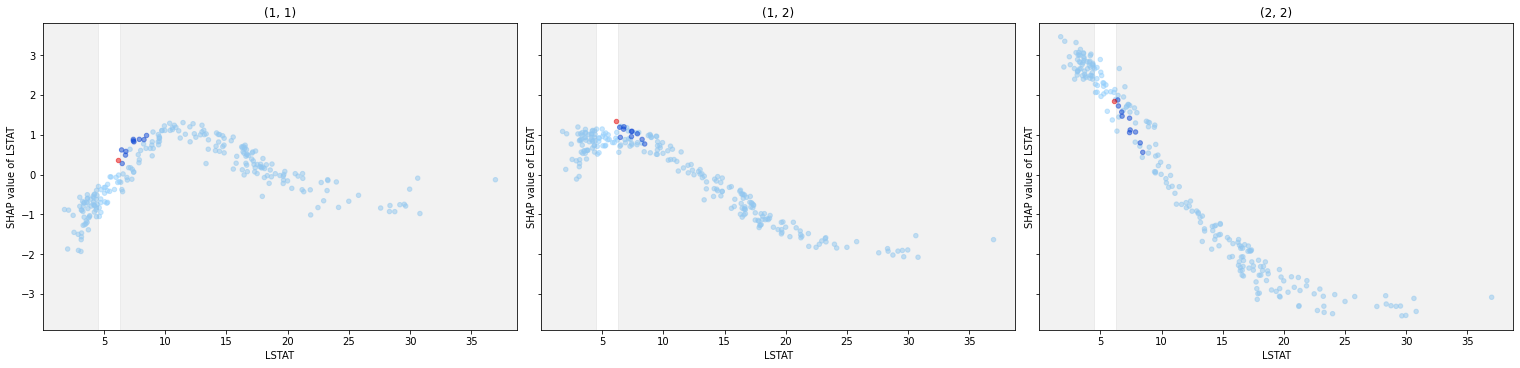

7.38 <= INDUS <= 7.38
INDUS >= 8.15 --> {'(1, 1)': 1}


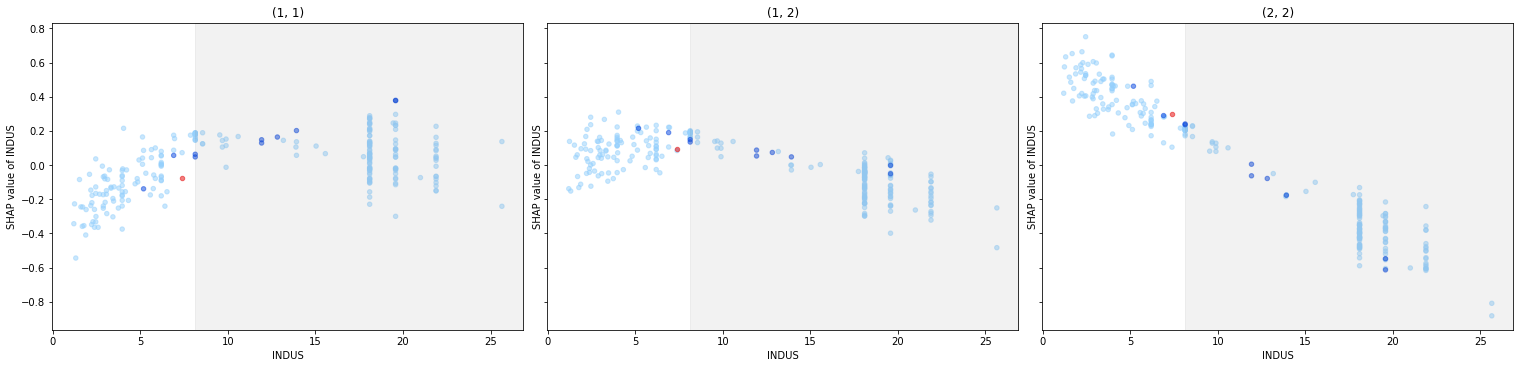

5.4159 <= DIS <= 5.4159
DIS <= 1.9 --> {'(2, 2)': 1}
DIS >= 5.66 --> {'(1, 1)': 1}


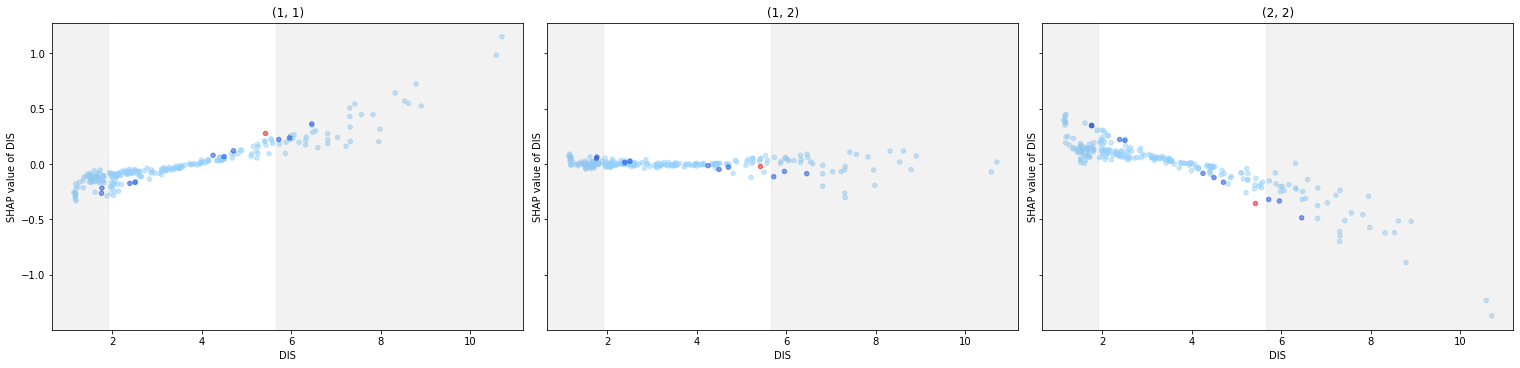

5.0 <= RAD <= 5.0
RAD <= 4.27 --> {'(1, 1)': 1}
RAD >= 12.73 --> {'(2, 2)': 1}


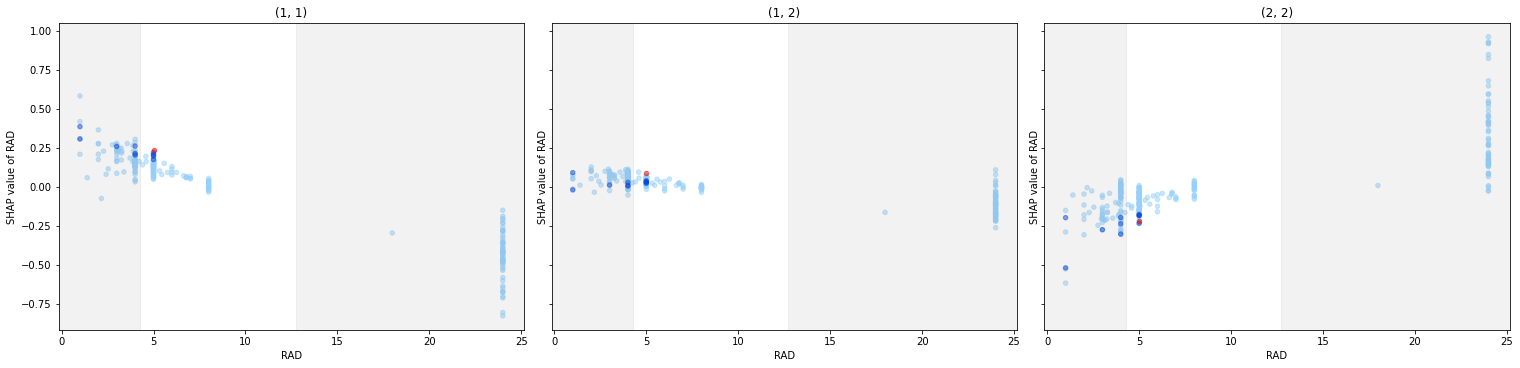

0.30347 <= CRIM <= 0.30347
CRIM >= 15.0 --> {'(0, 0)': 1}


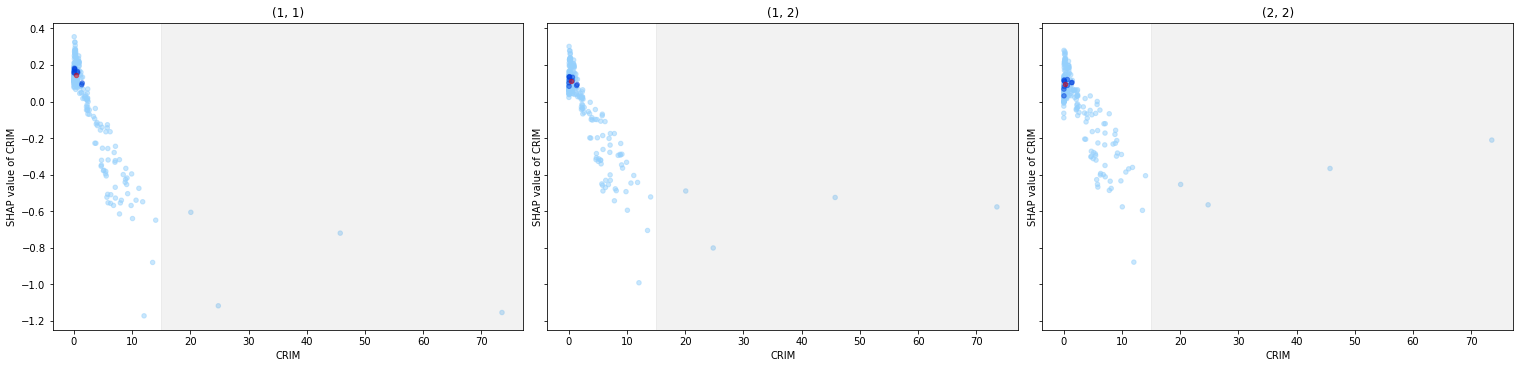

AGE <= 0.0
AGE >= 1.0 --> {'(1, 1)': 1}


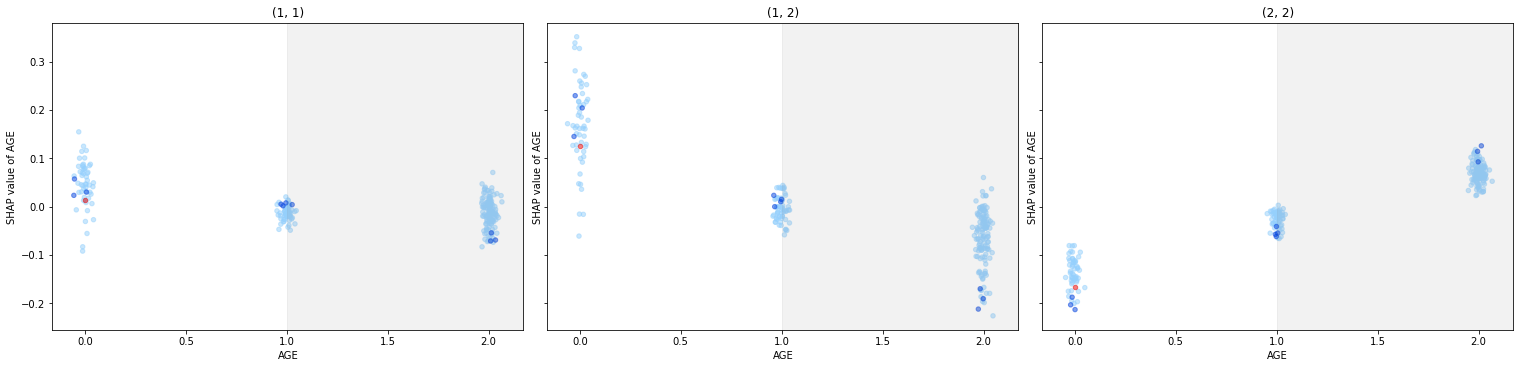

6.312 <= RM <= 6.312
RM <= 6.2 --> {'(1, 1)': 1}
RM >= 7.75 --> {'(2, 2)': 1}


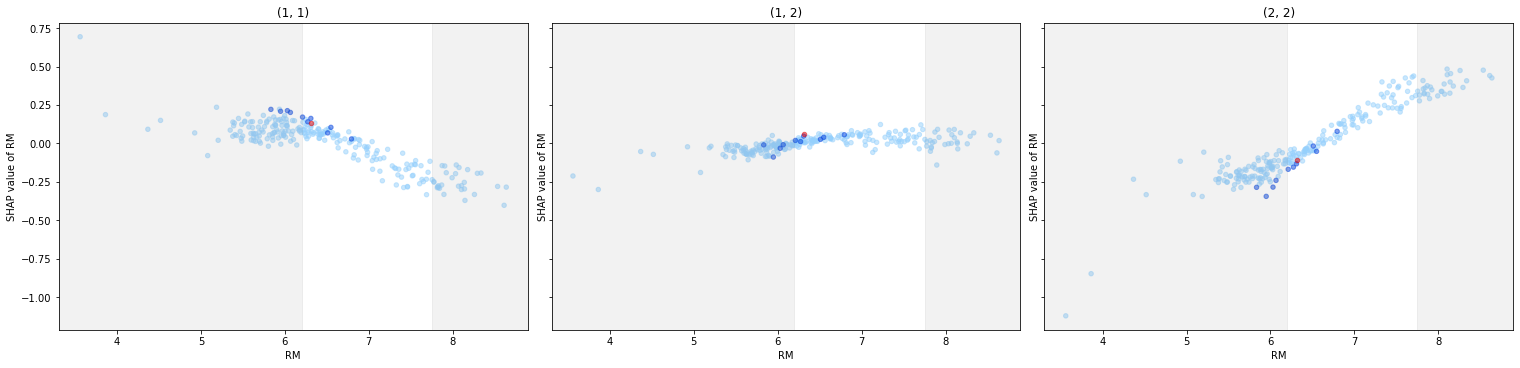

ZN <= 0.0
ZN >= 90.0 --> {'(2, 2)': 1}


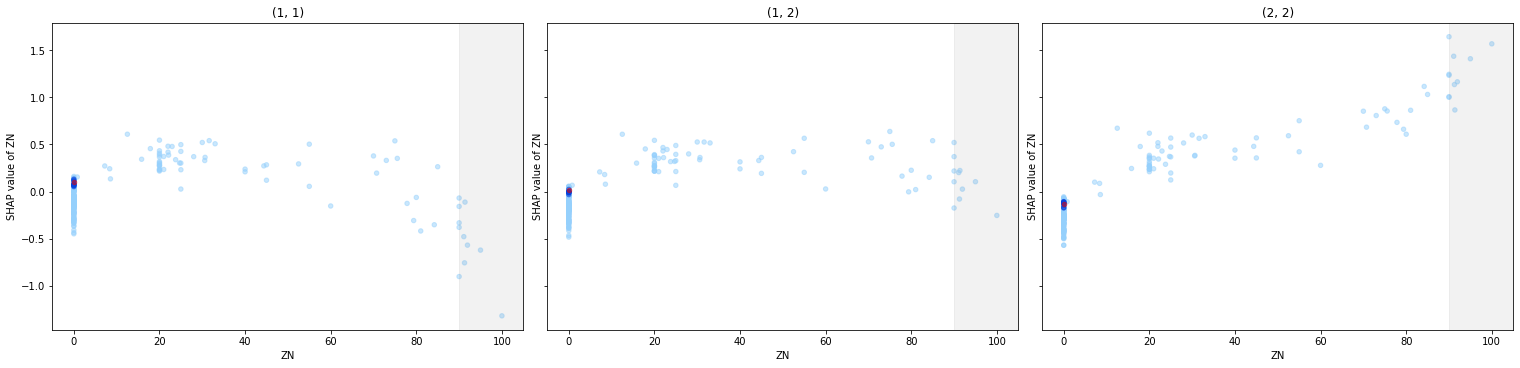

19.6 <= PTRATIO <= 19.6
PTRATIO <= 17.34 --> {'(1, 1)': 1}


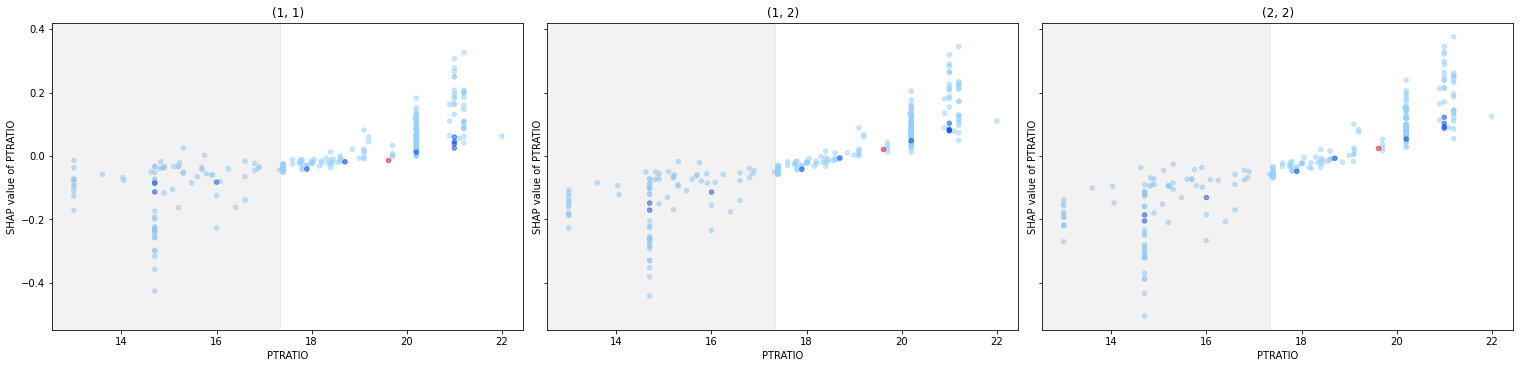

In [117]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

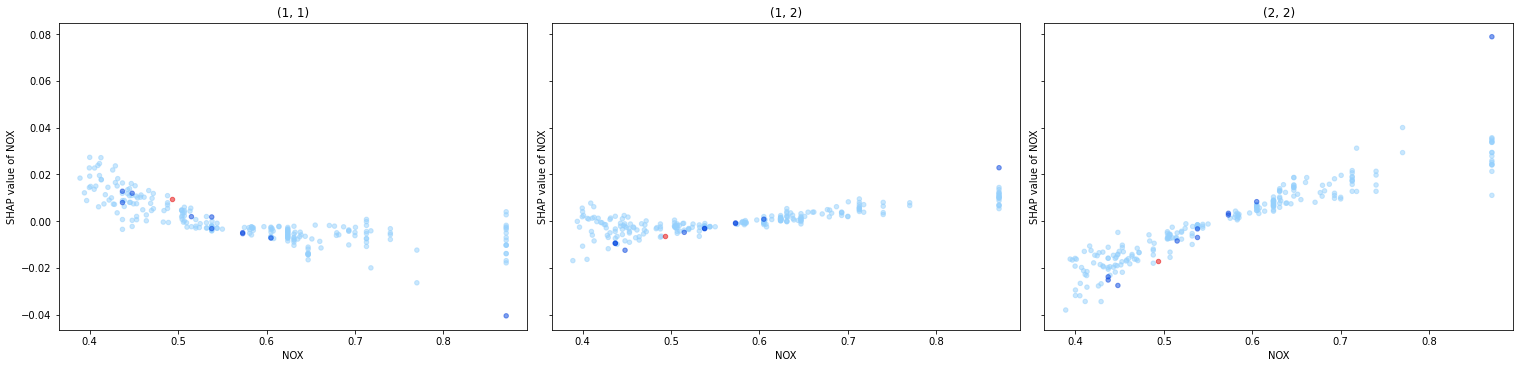

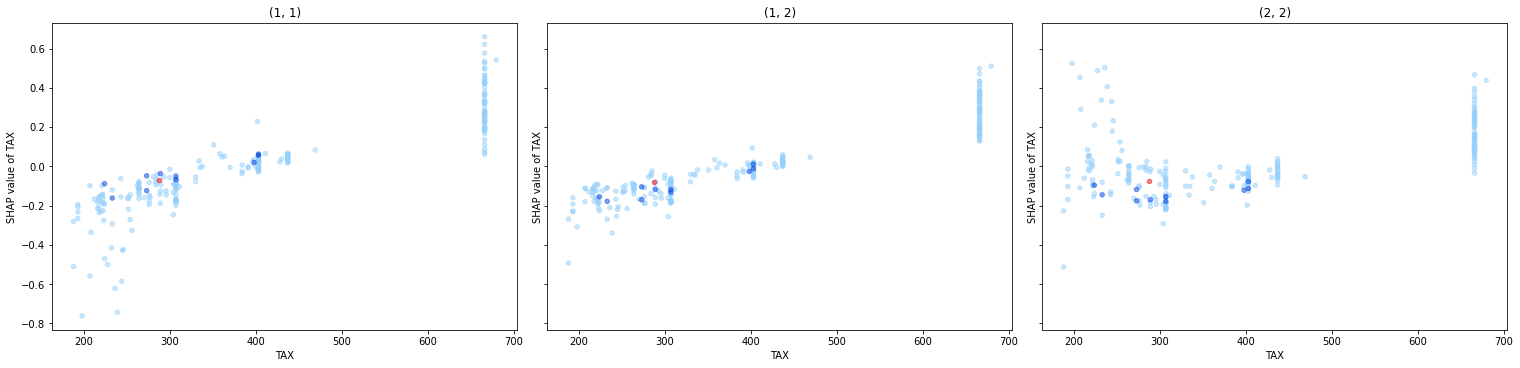

In [118]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

6.15 <= LSTAT <= 6.15
LSTAT <= 4.51 --> {'(2, 2)': 1}
LSTAT >= 6.28 --> {'(1, 1)': 1}


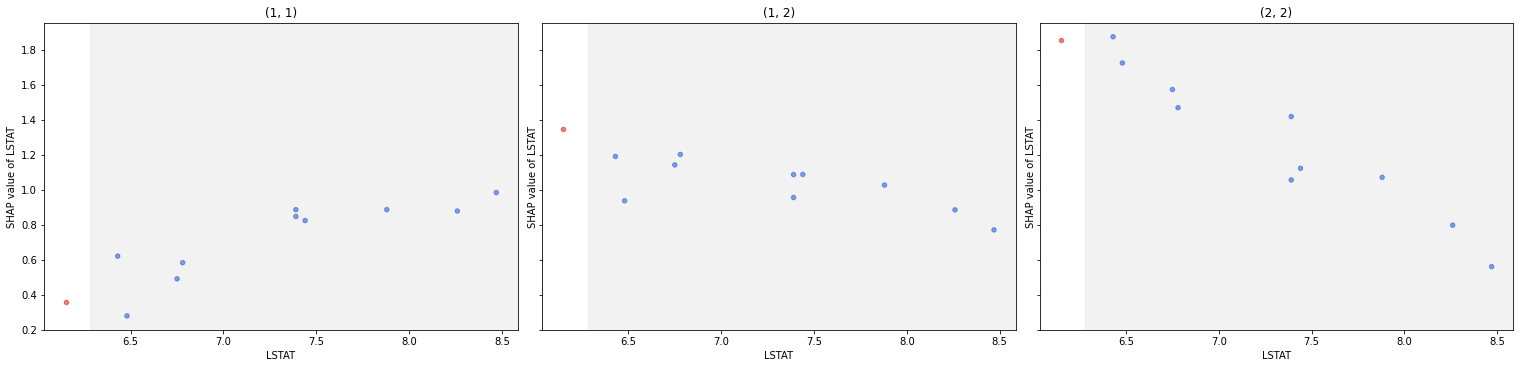

7.38 <= INDUS <= 7.38
INDUS >= 8.15 --> {'(1, 1)': 1}


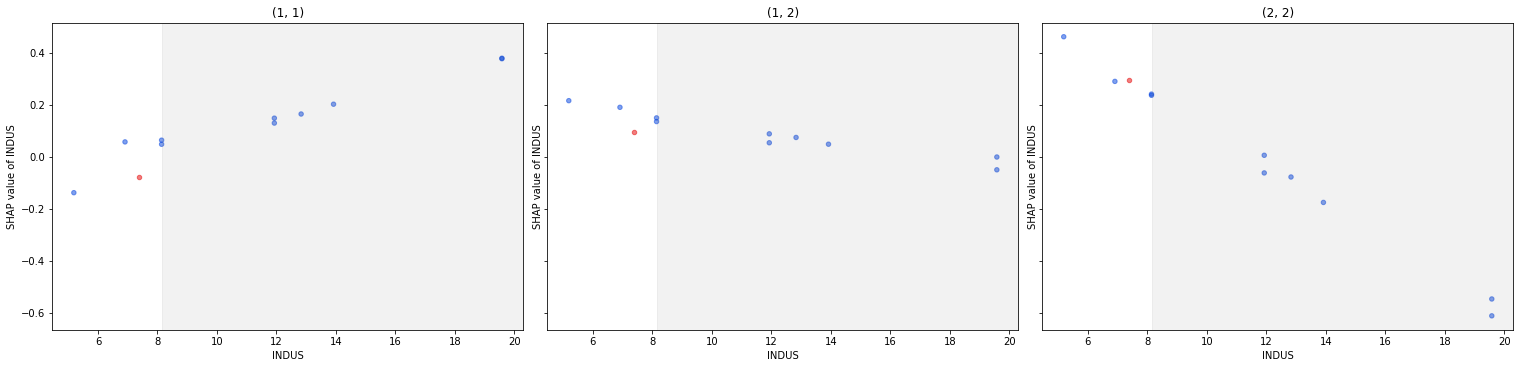

In [119]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature(feature, focus=node, alpha=0.5)

These are the explanations for the locally most important features.

## Clustering of Class $(2,1)$ SHAP Values

In [132]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(2, 1)', ['(1, 1)', '(2, 1)', '(2, 2)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node RRRL

In [133]:
node.class_counts, node.distance

((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 60.777823506026564)

In [134]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    95
 (1, 1)    36
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 26.81584836974085)

In [135]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    33
 (2, 2)    10
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 12.516453129655789)

In [136]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    20
 (2, 2)    10
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 11.142325438034494)

In [138]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    9
 (2, 1)    1
 dtype: int64,
 2.9821230696136807)

7.12 <= LSTAT <= 7.12
LSTAT <= 6.18 --> {'(2, 2)': 1}
LSTAT >= 7.42 --> {'(1, 1)': 1}


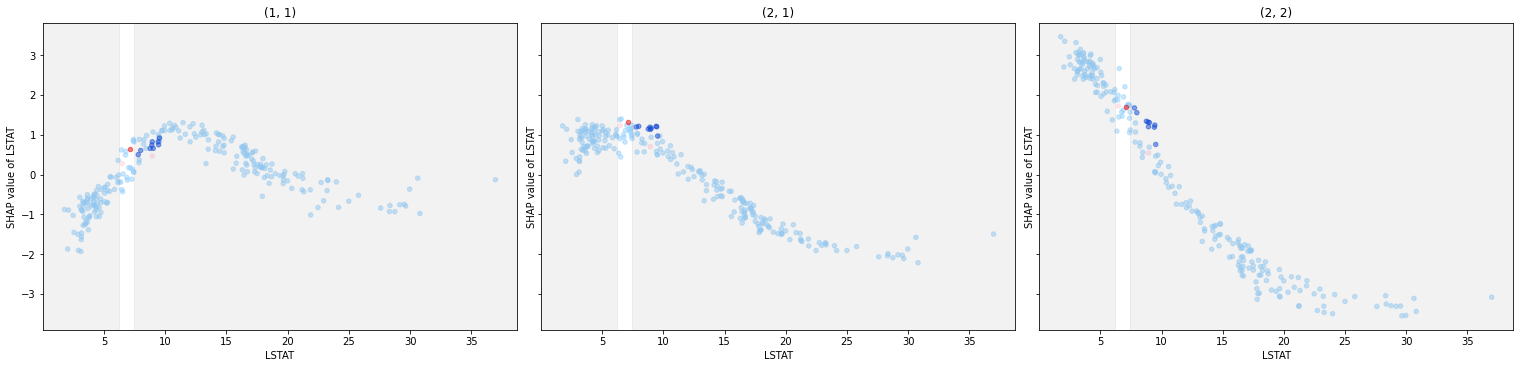

24.0 <= RAD
RAD <= 22.57 --> {'(1, 1)': 1}


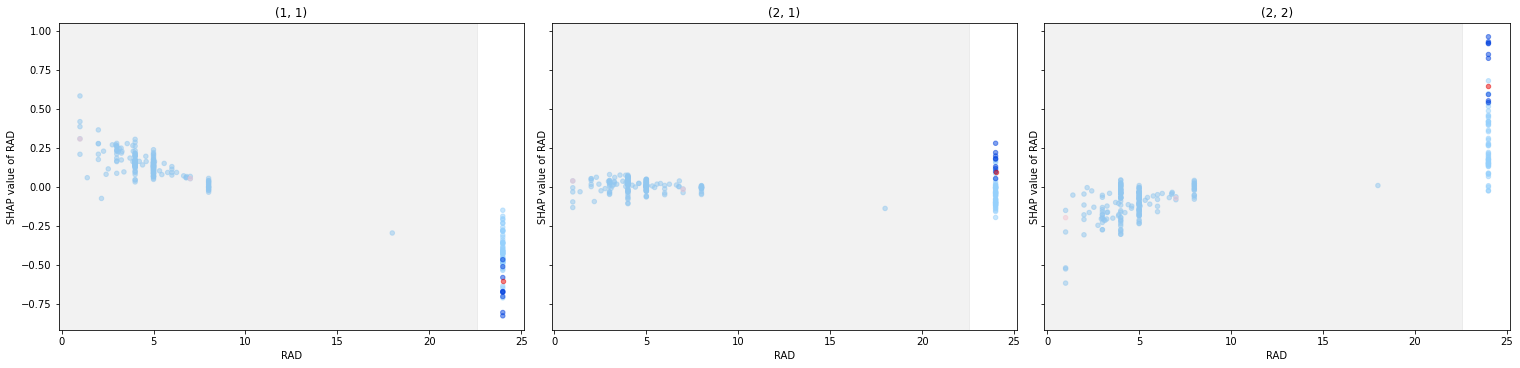

4.55587 <= CRIM <= 4.55587
CRIM <= 0.0 --> {'(1, 1)': 1}
CRIM >= 13.0 --> {'(0, 1)': 1}


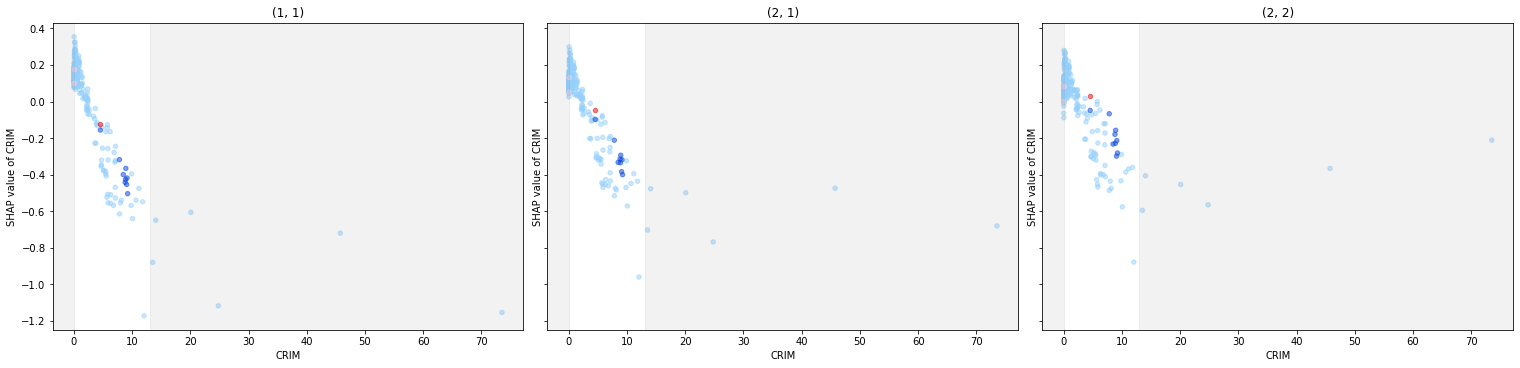

666.0 <= TAX <= 666.0
TAX <= 301.0 --> {'(1, 1)': 1}


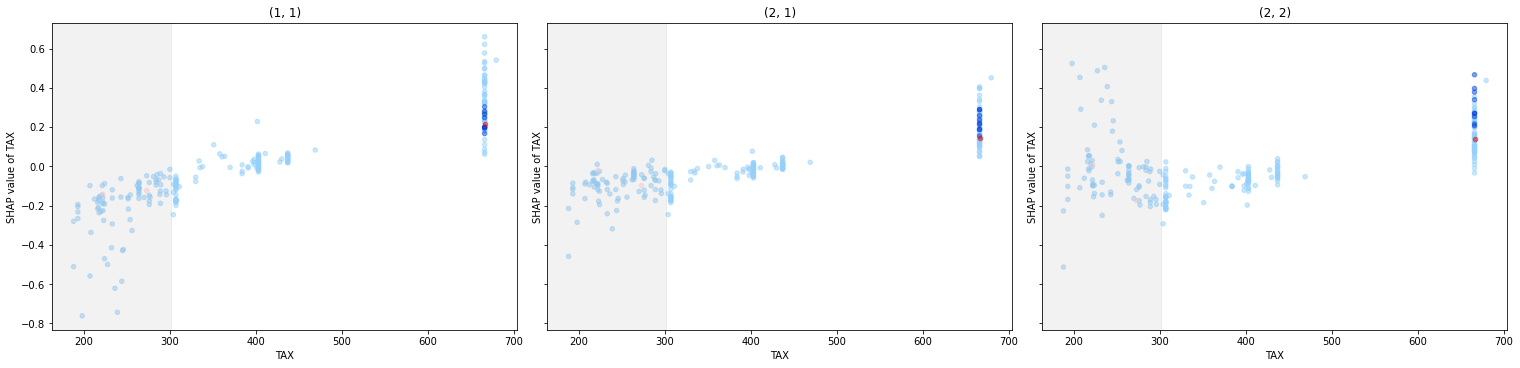

18.1 <= INDUS <= 18.1
INDUS <= 12.1 --> {'(2, 2)': 1}
INDUS >= 19.62 --> {'(1, 1)': 1}


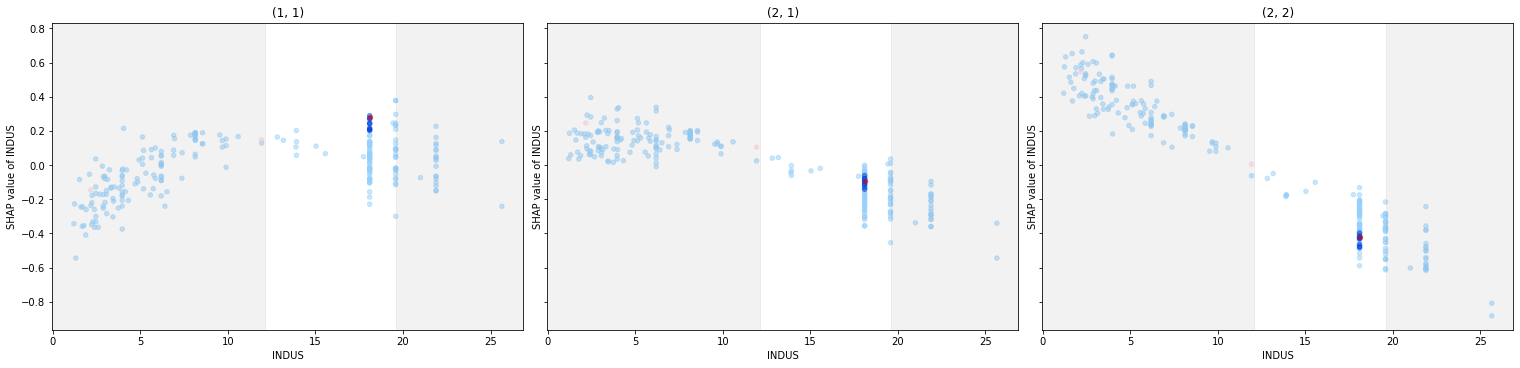

1.6132 <= DIS <= 1.6132
DIS >= 2.25 --> {'(1, 1)': 1}


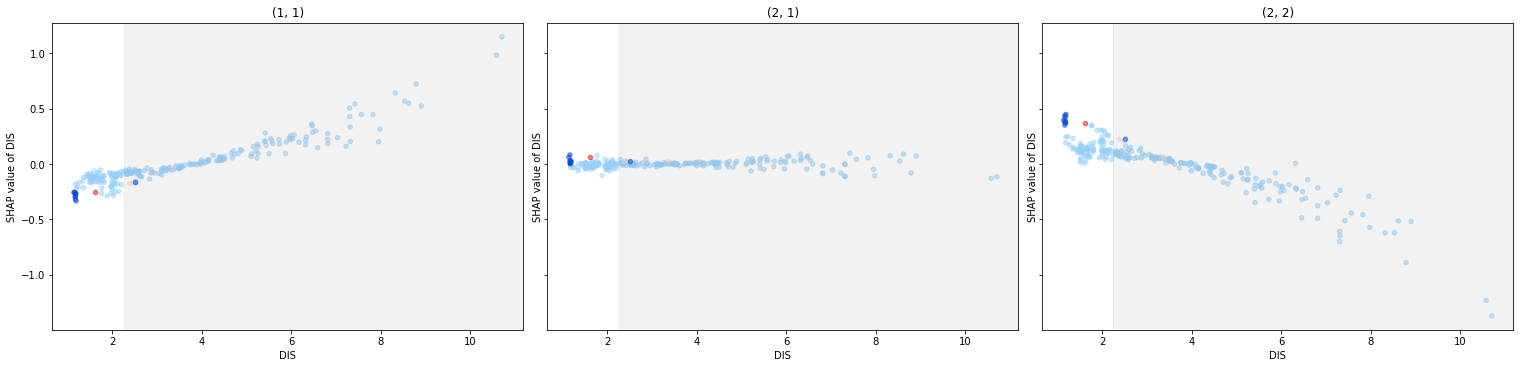

RM <= 3.561
RM >= 4.36 --> {'(2, 2)': 1}


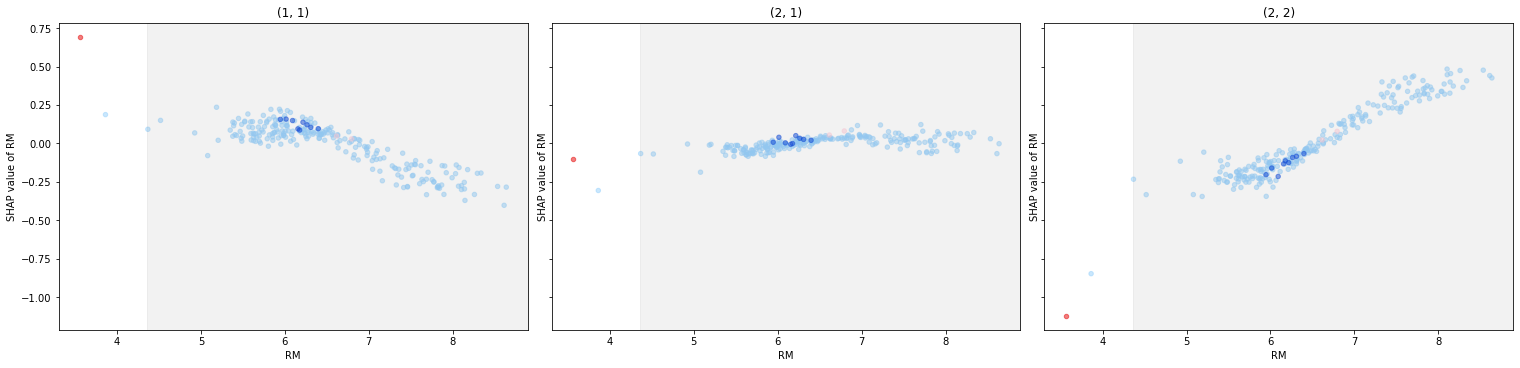

ZN <= 0.0
ZN >= 82.0 --> {'(2, 2)': 1}


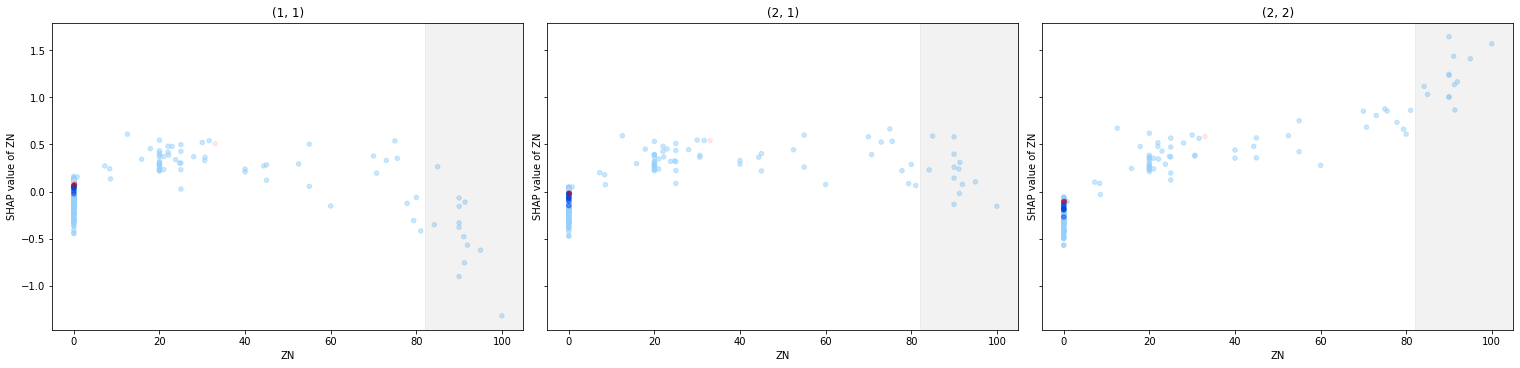

2.0 <= AGE
AGE <= 1.0 --> {'(1, 1)': 1}


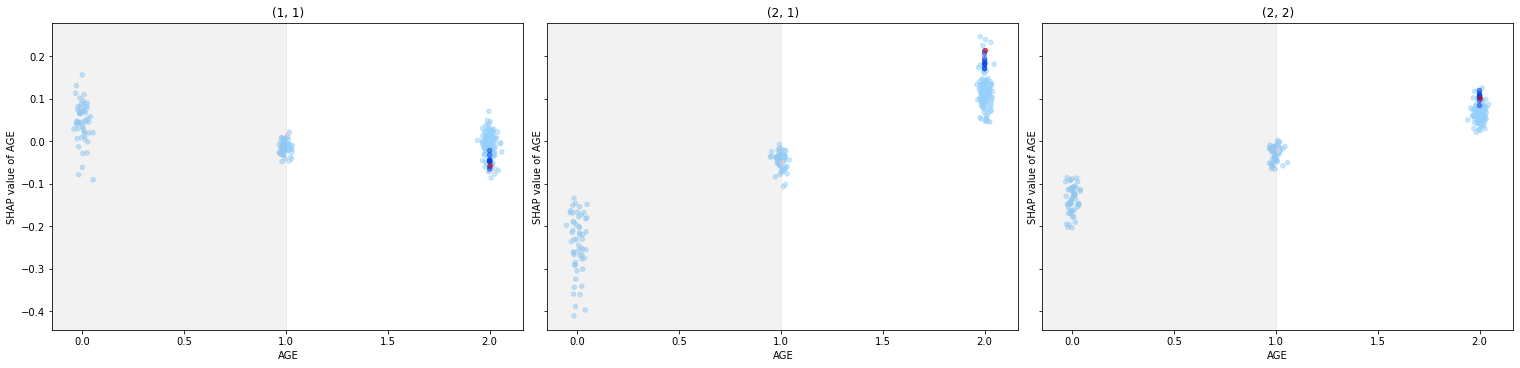

20.2 <= PTRATIO <= 20.2
PTRATIO <= 13.03 --> {'(1, 1)': 1}


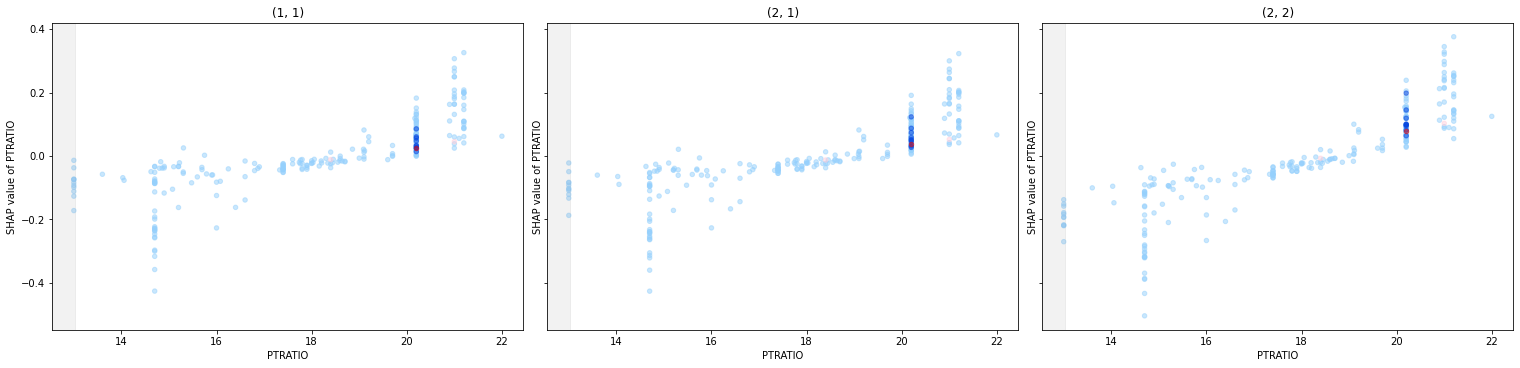

In [139]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

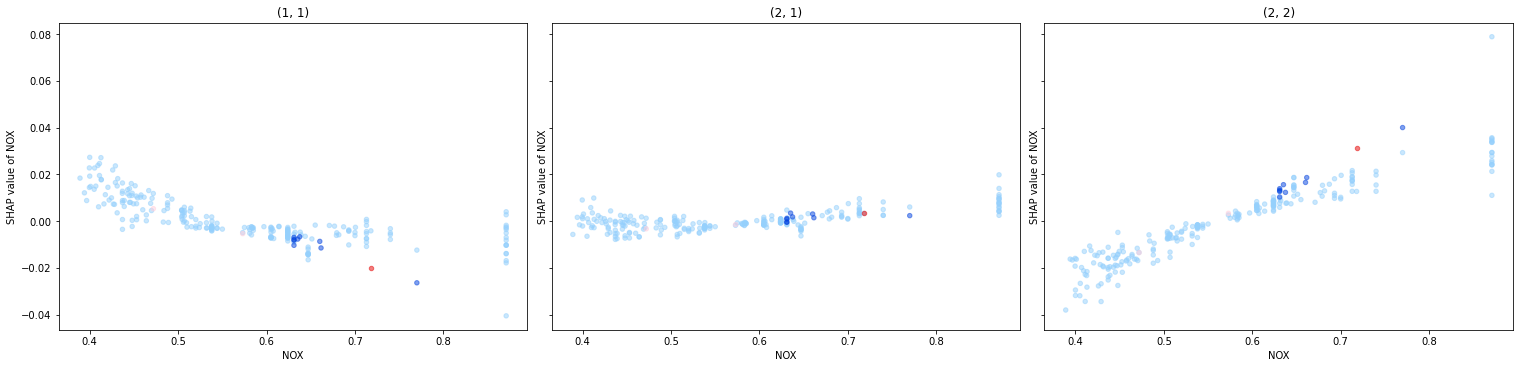

In [141]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

7.12 <= LSTAT <= 7.12
LSTAT <= 6.18 --> {'(2, 2)': 1}
LSTAT >= 7.42 --> {'(1, 1)': 1}


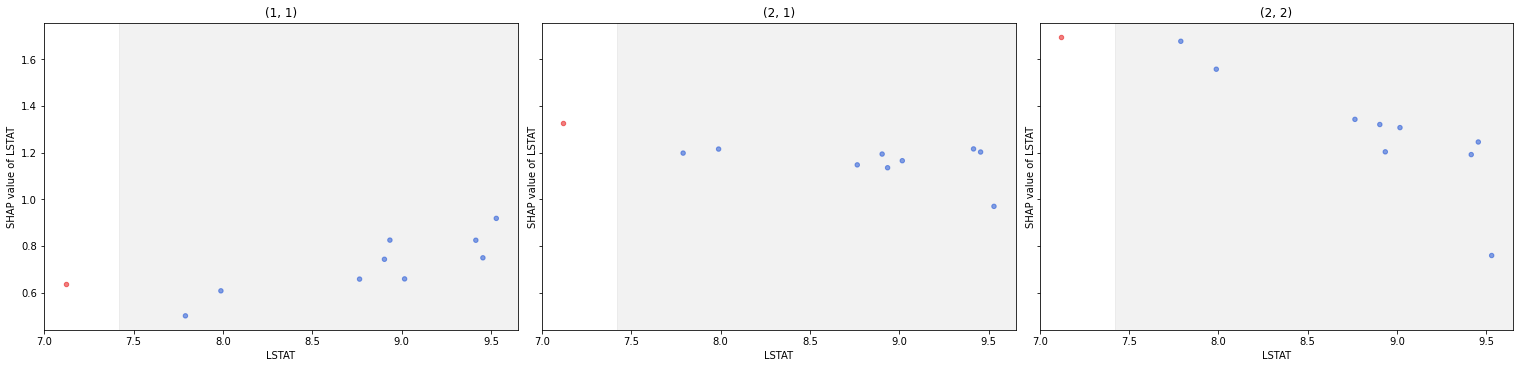

24.0 <= RAD
RAD <= 22.57 --> {'(1, 1)': 1}


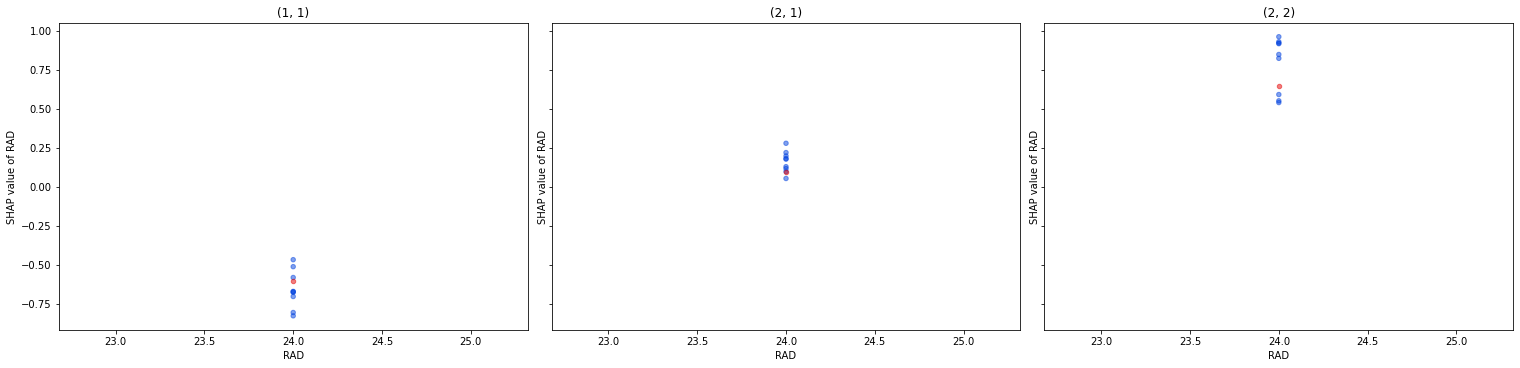

In [142]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature(feature, focus=node, alpha=0.5)

Besides these explanations, the instance has a particularly high TAX value, but the class doesn't change until 301, because of the smaller linear relations. Further, it can be considered an outlier because of its low RM value and low upper RM counterfactual.